# Система оценки риска ДТП

## Введение

Вы — специалист по Data Sciense в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.


## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns
import numpy as np
import torch 
import torch.nn as nn
import random

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, \
                            precision_recall_curve, \
                            confusion_matrix

pd. set_option('max_columns', None)

RANDOM_STATE = 12345

## Подключитесь к базе. Загрузите таблицы sql

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 
 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
engine = create_engine(connection_string) 

Загрузим таблицы sql.

### Общая информация о ДТП. Таблица collisions 

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда. 

In [4]:
# количество строк в базе данных
query = '''
SELECT COUNT(case_id)
FROM collisions;
'''

pd.read_sql_query(query, con=engine) 

,count
0,1400000


In [5]:
query = '''
SELECT *
FROM collisions
LIMIT 500;
'''

collisions_df = pd.read_sql_query(query, con=engine) 

### Информация об участниках ДТП. parties 

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

In [6]:
# количество строк в базе данных
query = '''
SELECT COUNT(id)
FROM parties;
'''

pd.read_sql_query(query, con=engine) 

,count
0,2752408


In [7]:
query = '''
SELECT *
FROM parties
LIMIT 500;
'''

parties_df = pd.read_sql_query(query, con=engine) 

### Информация о пострадавших машинах. vehicles 

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

In [8]:
# количество строк в базе данных
query = '''
SELECT COUNT(id)
FROM vehicles;
'''

pd.read_sql_query(query, con=engine) 

,count
0,1021234


In [9]:
query = '''
SELECT *
FROM vehicles
LIMIT 500;
'''

vehicles_df = pd.read_sql_query(query, con=engine) 

## Проведите первичное исследование таблиц

Посмотрим на первые строки всех трех таблиц и на информацию о них.

In [10]:
collisions_df.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [11]:
collisions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      500 non-null    object 
 1   county_city_location         500 non-null    object 
 2   county_location              500 non-null    object 
 3   distance                     500 non-null    float64
 4   direction                    344 non-null    object 
 5   intersection                 493 non-null    float64
 6   weather_1                    494 non-null    object 
 7   location_type                193 non-null    object 
 8   collision_damage             500 non-null    object 
 9   party_count                  500 non-null    int64  
 10  primary_collision_factor     491 non-null    object 
 11  pcf_violation_category       485 non-null    object 
 12  type_of_collision            495 non-null    object 
 13  motor_vehicle_involv

In [12]:
parties_df.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [13]:
parties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   500 non-null    int64  
 1   case_id              500 non-null    object 
 2   party_number         500 non-null    int64  
 3   party_type           490 non-null    object 
 4   at_fault             500 non-null    int64  
 5   insurance_premium    182 non-null    float64
 6   party_sobriety       452 non-null    object 
 7   party_drug_physical  267 non-null    object 
 8   cellphone_in_use     264 non-null    float64
dtypes: float64(2), int64(3), object(4)
memory usage: 35.3+ KB


In [14]:
vehicles_df.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


In [15]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    500 non-null    int64  
 1   case_id               500 non-null    object 
 2   party_number          500 non-null    int64  
 3   vehicle_type          500 non-null    object 
 4   vehicle_transmission  496 non-null    object 
 5   vehicle_age           491 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 23.6+ KB


### Вывод

Количество загруженных таблиц – 3. Это соответствует условию задачи.

Для связи таблиц имеется общий ключ - case_id.

Все таблицы непустые. В таблице collisions 1 400 000 строк, 20 характеристик. В таблице parties 2 752 408 строк, 9 характеристик. В таблице vehicles 1 021 234 строк, 6 характеристик. 

По результатам выгрузки можно составить **описание данных**.


**collisions — общая информация о ДТП**

- **case_id** - идентификационный номер в базе данных
- **collision_damage** - серьёзность происшествия
- **collision_date** - дата происшествия
- **collision_time** - время происшествия
- **control_device** - устройство управления
- **county_city_location** - номер географических районов, где произошло ДТП
- **county_location** - названия географических районов, где произошло ДТП
- **direction** - направление движения
- **distance** - расстояние от главной дороги (метры)
- **intersection** - является ли место происшествие перекрёстком
- **lighting** - освещение
- **location_type** - тип дороги
- **motor_vehicle_involved_with** - дополнительные участники ДТП
- **party_count** - количество участников
- **pcf_violation_category** - категория нарушения
- **primary_collision_factor** - основной фактор аварии
- **road_condition_1** - дорожное состояние (определяется по степени изношенности)
- **road_surface** - состояние дороги (определяется по погодным условиям)
- **type_of_collision** - тип аварии
- **weather_1** - погода


**parties - описание участников происшествия**

- **at_fault** - виновность участника
- **case_id** - идентификационный номер в базе данных
- **cellphone_in_use** - наличие телефона в автомобиле (возможности разговаривать по громкой связи)
- **id** - индекс текущей таблицы
- **insurance_premium** - сумма страховки (тыс. $)
- **party_drug_physical** - состояние участника: физическое или с учётом принятых лекарств
- **party_number** - номер участника происшествия
- **party_sobriety** - трезвость участника
- **party_type** - тип участника происшествия


**vehicles - описание автомобиля**

- **case_id** - идентификационный номер в базе данных
- **id** - индекс текущей таблицы
- **party_number** - номер участника происшествия
- **vehicle_age** - возраст автомобиля (в годах)
- **vehicle_transmission** - тип КПП
- **vehicle_type** - тип кузова


Для дальнейшей работы нам не нужны все данные, а только часть. Поэтому удалим созданные переменные и сформируем новый SQL запрос.

In [16]:
del collisions_df
del parties_df
del vehicles_df

##  Проведите статистический анализ факторов ДТП

Проанализируем весь период наблюдений и выясним, в какие месяцы происходит наибольшее количество ДТП.

Посмотрим, за сколько месяцев есть данные в зависимости от года.

In [17]:
query = '''
SELECT EXTRACT('year' FROM collision_date) AS year,
    EXTRACT('month' FROM collision_date) AS month,
    COUNT('case_id')
FROM collisions
GROUP BY EXTRACT('year' FROM collision_date), EXTRACT('month' FROM collision_date);
'''

pd.read_sql_query(query, con=engine)

,year,month,count
0,2009.0,1.0,35062
1,2009.0,2.0,34480
2,2009.0,3.0,36648
3,2009.0,4.0,35239
4,2009.0,5.0,36916
5,2009.0,6.0,34202
6,2009.0,7.0,35161
7,2009.0,8.0,34508
8,2009.0,9.0,35555
9,2009.0,10.0,37835


Видим, что полностью хранятся данные только с 2009 по 2011 годы. C июня 2012 количество данных резко уменьшается.

Поэтому для анализа количества аварий по месяцам будем рассматривать только период до 2012 года.


In [18]:
query = '''
SELECT ROUND(EXTRACT('month' FROM collision_date)) AS month,
    COUNT('case_id')
FROM collisions
WHERE EXTRACT('year' FROM collision_date) < 2012
GROUP BY EXTRACT('month' FROM collision_date);
'''

months_statistics = pd.read_sql_query(query, con=engine) 

In [19]:
# количество аварий по месяцам
months_statistics

,month,count
0,1.0,99880
1,2.0,98373
2,3.0,107036
3,4.0,101032
4,5.0,105148
5,6.0,99531
6,7.0,101835
7,8.0,103467
8,9.0,104649
9,10.0,111933


Представим результаты расчетов в виде столбчатой диаграммы.

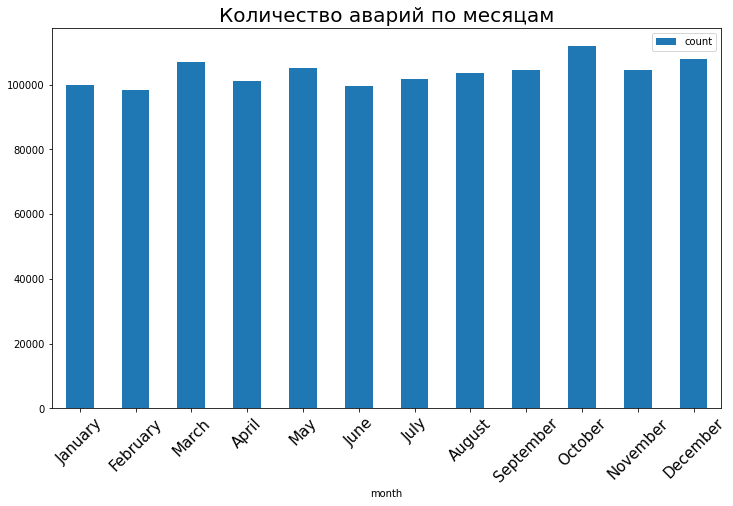

In [20]:
chart = months_statistics.plot(
    kind='bar', 
    x='month',
    figsize=(12, 7),
rot=45)
chart.set_xticklabels(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], 
    fontsize=15
)
chart.set_title('Количество аварий по месяцам', fontsize=20);

Видим, что самые аварийные месяцы года - октябрь, декабрь и март. Скорее всего это связано с состоянием весенних дорог.


## Задачи для рабочей группы

Скоро состоится первое совещание рабочей группы. Чтобы сотрудники понимали данные, им необходимо решить следующие задачи.

**Задача 1.**

Проведите анализ серьезности повреждений транспортного средства, исходя из состояния дороги в момент ДТП.

**Задача 2.**

Найдите самые частые причины ДТП.

**Задача 3.**

Для каждого значения возраста автомобиля определите средний и медианный размер страховых выплат для виновников ДТП и для пострадавших.

**Задача 4.**

Проведите анализ серьезности повреждений транспортного средства, исходя из уровня трезвости водителя.

**Задача 5.**

Для каждого типа автомобиля определите средний размер страховых выплат для виновников ДТП .

- создайте SQL-запрос, который покажет размер страховых выплат для виновников аварии 
- постройте диаграмму, где для каждого типа авто будут видны средние выплаты виновников.
- сделайте вывод

In [21]:
query = '''
SELECT v.vehicle_type,
    AVG(p.insurance_premium) AS avg_insurance_premium
FROM vehicles AS v
JOIN parties AS p ON v.case_id = p.case_id
GROUP BY v.vehicle_type;
'''

v_type_insurance = pd.read_sql_query(query, con=engine) 

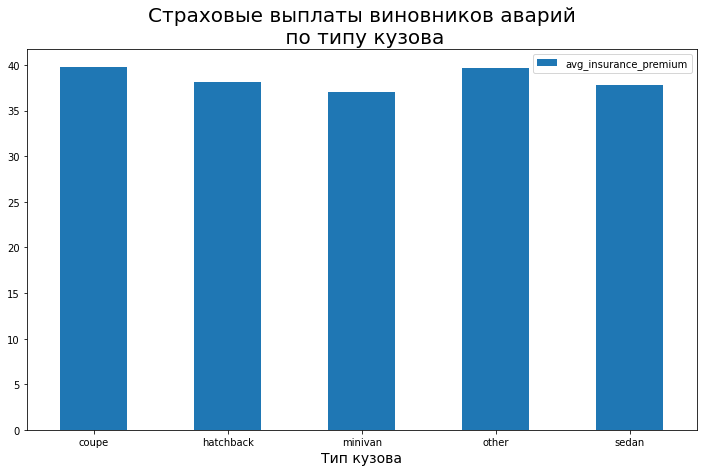

In [22]:
chart = v_type_insurance.plot(
    kind='bar', 
    x='vehicle_type',
    y='avg_insurance_premium',
    figsize=(12, 7),
rot=0)

chart.set_xlabel('Тип кузова', fontsize=14)
chart.set_title('Страховые выплаты виновников аварий\n по типу кузова', fontsize=20);

**Вывод**: 

Видим, что средний размер выплат отличается незначительно в зависимости от типа кузова. Но выше всего страховые выплаты у владельцев машин типа купе и в группе авто, где тип кузова не указан.

**Задача 6.**

Проанализируйте весь период наблюдений и выясните, в какое время суток происходит больше всего аварий. Проанализируйте только те случаи, где виновник ДТП - машина.
- создайте SQL-запрос, который покажет среднее количество аварий в каждый час суток.
- постройте столбчатую диаграмму, опираясь на результаты выдачи.
- сделайте вывод о наиболее опасных часах.

In [23]:
query = '''
SELECT EXTRACT('hour' FROM collision_time) AS hour,
    COUNT('case_id')
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id 
WHERE EXTRACT('hour' FROM collision_time) < 24 AND p.at_fault = 1 AND p.party_type = 'car'
GROUP BY EXTRACT('hour' FROM collision_time);
'''

hour_stat = pd.read_sql_query(query, con=engine)

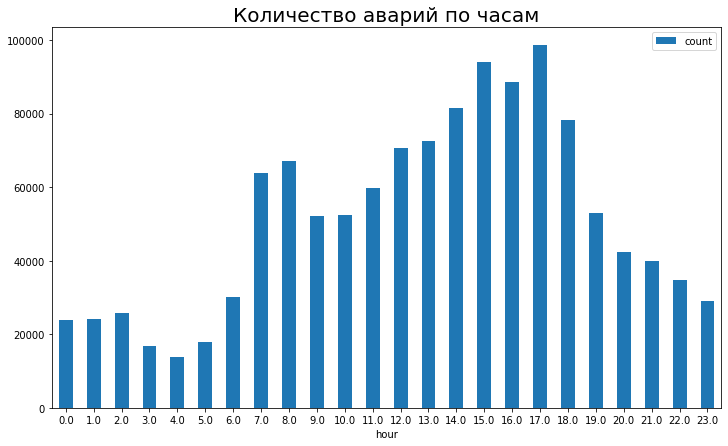

In [24]:
chart = hour_stat.plot(
    kind='bar', 
    x='hour',
    figsize=(12, 7),
rot=0)

chart.set_title('Количество аварий по часам', fontsize=20);

**Вывод**: 
    
Видим, что наиболее опасный период – с 14.00 до 18.00.

## Создайте модель для оценки водительского риска

### Подготовка датасета

Для проведения статистического анализа отберем аварии, которые подходят под критерии, описанные заказчиком:
- тип виновника — только машина (car).
- случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- ограничиться данными за 2012 год


Проведем первичный отбор факторов, необходимых для модели. 

|столбец|аргументация решения|
|:---|:----|
| id | не влияет на вероятность аварии |
| case_id | не влияет на вероятность аварии |
| party_number | не влияет на вероятность аварии |
| party_type | уберем, потому что значение одинаково для всех строк – car|
| **at_fault** | целевой признак|
| insurance_premium | не берем, потому что сумма страховых выплат неизвестна до аварии, и не будет доступна для модели после развертывания|
| **party_sobriety** | оказывает влияние|
| **party_drug_physical** | оказывает влияние |
| **cellphone_in_use** | оказывает влияние |
| case_id ||
| **county_city_location** |может оказывать влияние|
| county_location | может оказывать влияние, но дублирует county_city_location, которое удобнее в работе, потому что представляет собой число |
| **distance** | может оказывать влияние |
| **direction** | может оказывать влияние |
| intersection | место аварии не известно до самой аварии |
| **weather_1** | оказывает влияние |
| **location_type** | оказывает влияние |
| collision_damage | не берем, потому что неизвестно до аварии, и не будет доступна для модели после развертывания |
| party_count | неизвестно до аварии |
| primary_collision_factor | неизвестно до аварии |
| pcf_violation_category | неизвестно до аварии |
| type_of_collision | неизвестно до аварии |
| motor_vehicle_involved_with | неизвестно до аварии |
| **road_surface** | может оказывать влияние, если в крашеринге есть возможность получить от пользователя маршрут его предстоящей поездки, то можно собрать эти данные для модели|
| **road_condition_1** | может оказывать влияние, если в крашеринге есть возможность получить от пользователя маршрут его предстоящей поездки, то можно собрать эти данные для модели |
| **lighting** | может оказывать влияние |
| **control_device** | оказывает влияние |
| **collision_date** | оказывает влияние, при развертке модели можно использовать дату взятия машины в аренду |
| collision_time | неизвестно до аварии |
| id | не влияет на вероятность аварии |
| case_id | не влияет на вероятность аварии |
| party_number | неизвестно до аварии |
| **vehicle_type** | может оказывать влияние |
| **vehicle_transmission** | может оказывать влияние |
| **vehicle_age** | может оказывать влияние |


In [25]:
query = '''
SELECT 
    p.at_fault,
    p.party_sobriety, 
    p.party_drug_physical,
    p.cellphone_in_use, 
    c.county_city_location,
    c.distance, 
    c.direction,
    c.weather_1,
    c.location_type, 
    c.road_surface,
    c.road_condition_1, 
    c.lighting, 
    c.control_device, 
    c.collision_date,
    v.vehicle_type,
    v.vehicle_transmission, 
    v.vehicle_age
FROM parties AS p
JOIN collisions AS c ON p.case_id = c.case_id
LEFT JOIN vehicles AS v ON p.case_id = v.case_id
WHERE (p.party_type = 'car')
    AND (EXTRACT(YEAR FROM c.collision_date) = 2012)
    AND (c.collision_damage NOT LIKE 'scratch');
'''

df_of_collisions = pd.read_sql_query(query, con=engine) 

In [26]:
def first_look(df, num_of_srtings=5):
    '''
    функция для первичного знакомства с данными
    '''
    print('Общая информация')
    display(df.info())
    
    print(f'Первые {num_of_srtings} строк(и) данных')
    display(df.head(num_of_srtings))
    
    print('Основные статистические характеристики данных')
    display(df.describe())
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    
    print('Количество дубликатов:', df.duplicated().sum())

In [27]:
first_look(df_of_collisions)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226984 entries, 0 to 226983
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              226984 non-null  int64  
 1   party_sobriety        222960 non-null  object 
 2   party_drug_physical   26431 non-null   object 
 3   cellphone_in_use      199291 non-null  float64
 4   county_city_location  226984 non-null  object 
 5   distance              226984 non-null  float64
 6   direction             175734 non-null  object 
 7   weather_1             226205 non-null  object 
 8   location_type         101712 non-null  object 
 9   road_surface          225492 non-null  object 
 10  road_condition_1      225678 non-null  object 
 11  lighting              226177 non-null  object 
 12  control_device        225905 non-null  object 
 13  collision_date        226984 non-null  object 
 14  vehicle_type          118411 non-nu

None

Первые 5 строк(и) данных


,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,county_city_location,distance,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,vehicle_type,vehicle_transmission,vehicle_age
0,1,had not been drinking,None,0.0,1912,0.0,west,clear,None,dry,normal,dark with street lights,functioning,2012-01-18,None,None,NaN
1,1,impairment unknown,G,0.0,3400,55.0,west,clear,None,dry,normal,dark with street lights,none,2012-01-09,None,None,NaN
2,1,impairment unknown,G,0.0,3607,1056.0,west,cloudy,highway,wet,normal,daylight,none,2012-01-23,None,None,NaN
3,1,None,None,NaN,5002,2640.0,north,clear,highway,dry,normal,dark with street lights,None,2012-01-07,sedan,auto,4.0
4,0,had not been drinking,None,0.0,1941,220.0,south,clear,None,dry,normal,dark with street lights,none,2012-01-08,None,None,NaN


Основные статистические характеристики данных


,at_fault,cellphone_in_use,distance,vehicle_age
count,226984.000000,199291.000000,2.269840e+05,115046.000000
mean,0.505652,0.023393,6.629733e+02,4.908263
std,0.499969,0.151148,7.402612e+03,3.266265
min,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,1.000000e+01,3.000000
50%,1.000000,0.000000,1.000000e+02,4.000000
75%,1.000000,0.000000,5.000000e+02,7.000000
max,1.000000,1.000000,1.584000e+06,161.000000


Количество пропусков:
at_fault                     0
party_sobriety            4024
party_drug_physical     200553
cellphone_in_use         27693
county_city_location         0
distance                     0
direction                51250
weather_1                  779
location_type           125272
road_surface              1492
road_condition_1          1306
lighting                   807
control_device            1079
collision_date               0
vehicle_type            108573
vehicle_transmission    110439
vehicle_age             111938
dtype: int64

Количество дубликатов: 22611


### Анализ данных

Посмотрим на дубликаты.

In [28]:
df_of_collisions[df_of_collisions.duplicated()]

,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,county_city_location,distance,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,vehicle_type,vehicle_transmission,vehicle_age
17,0,had not been drinking,None,0.0,5604,200.0,north,clear,highway,dry,normal,daylight,none,2012-02-08,sedan,auto,5.0
33,1,had not been drinking,None,0.0,3001,108.0,south,clear,None,dry,normal,dark with street lights,none,2012-03-09,coupe,auto,4.0
69,0,had not been drinking,None,0.0,3400,0.0,None,cloudy,None,dry,normal,daylight,functioning,2012-01-24,None,None,NaN
75,0,had not been drinking,None,0.0,1955,0.0,None,clear,None,dry,normal,daylight,functioning,2012-02-03,None,None,NaN
86,0,had not been drinking,None,0.0,0105,2640.0,south,clear,highway,dry,normal,daylight,none,2012-02-02,coupe,auto,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226945,0,had not been drinking,None,0.0,3313,358.0,west,clear,None,dry,normal,dusk or dawn,functioning,2012-02-06,None,None,NaN
226955,0,had not been drinking,None,0.0,1985,492.0,east,cloudy,None,dry,normal,daylight,none,2012-01-26,coupe,auto,3.0
226956,0,had not been drinking,None,0.0,1985,492.0,east,cloudy,None,dry,normal,daylight,none,2012-01-26,coupe,auto,5.0
226957,0,had not been drinking,None,0.0,1985,492.0,east,cloudy,None,dry,normal,daylight,none,2012-01-26,sedan,auto,12.0


Так как дубликаты не несут в себе информации, способной улучшить качество предсказаний, удалим их.

In [29]:
df_of_collisions.drop_duplicates(inplace=True)

In [30]:
df_of_collisions.shape

(204373, 17)

In [31]:
# контроль количества дубликатов
df_of_collisions.duplicated().sum()

0

Посмотрим соотношение классов целевой переменной

In [32]:
df_of_collisions['at_fault'].value_counts() / df_of_collisions.shape[0] * 100

1    55.525436
0    44.474564
Name: at_fault, dtype: float64

Видим, что классы 0 и 1 распределены примерно одинаково. Для моделей укажем параметр class_weight, чтобы учесть небольшой перекос.

Посмотрим подробнее на имеющиеся характеристики.

**Трезвость участника**

In [33]:
df_of_collisions['party_sobriety'].unique()

array(['had not been drinking', 'impairment unknown', None,
       'had been drinking, under influence',
       'had been drinking, impairment unknown',
       'had been drinking, not under influence', 'not applicable'],
      dtype=object)

In [34]:
df_of_collisions['party_sobriety'].value_counts()

had not been drinking                     163200
impairment unknown                         21008
had been drinking, under influence         11337
had been drinking, impairment unknown       1776
not applicable                              1685
had been drinking, not under influence      1549
Name: party_sobriety, dtype: int64

Видим, что в данных имеется четыре ключевых варианта трезвости: был трезв, был нетрезв, неприменимо, неизвестно. Оставим только их.

In [35]:
sobriety_to_replace = {
    "had been drinking, under influence" : "had been drinking",
    "had been drinking, impairment unknown" : "had been drinking",
    "had been drinking, not under influence" : "had been drinking",
    None : "impairment unknown"
}

# проводим замену
df_of_collisions['party_sobriety'].replace(sobriety_to_replace, inplace=True)

In [36]:
df_of_collisions['party_sobriety'].value_counts()

had not been drinking    163200
impairment unknown        24826
had been drinking         14662
not applicable             1685
Name: party_sobriety, dtype: int64

Посмотрим на количество аварий в зависимости от уровня трезвости и на количество виновников ДТП и пострадавших.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


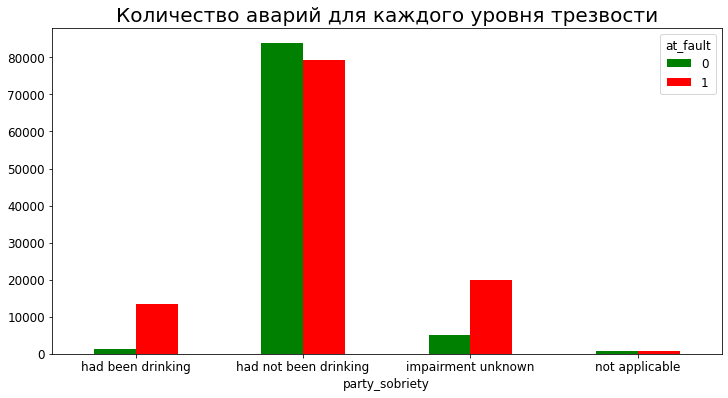

In [37]:
font = {'family' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

chart = df_of_collisions.groupby(
    ['party_sobriety', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий для каждого уровня трезвости', fontsize=20);

Видим, что если водитель был нетрезв, то он был виновником аварии гораздо чаще.

In [38]:
# процент разных по трезвости водителей среди виновников ДТП
df_of_collisions[df_of_collisions['at_fault'] == 1]['party_sobriety'].value_counts() \
/ df_of_collisions[df_of_collisions['at_fault'] == 1].shape[0] * 100

had not been drinking    69.952150
impairment unknown       17.516016
had been drinking        11.782797
not applicable            0.749037
Name: party_sobriety, dtype: float64

С другой стороны, в большинстве случаев (70 %) виновник ДТП был трезв.

**Состояние участника: физическое или с учётом принятых лекарств**

In [39]:
# список уникальных значений
df_of_collisions['party_drug_physical'].unique()

array([None, 'G', 'impairment - physical', 'under drug influence',
       'sleepy/fatigued', 'not applicable'], dtype=object)

In [40]:
# процент пропусков
df_of_collisions['party_drug_physical'].isna().sum() / df_of_collisions.shape[0] * 100

87.24733697699793

Среди уникальных значений столбца с описанием физического состояния есть значение G – не известно. В описании к данным нам дана расшифровка этого кода – impairment unknown. Можно заменить G этим словосочетанием для сохранения единообразия. Кроме того, можно использовать это значение для заполнения пропусков.

In [41]:
# словарь для замены
physical_to_replace = {
    None : 'impairment unknown',
    'G': 'impairment unknown'
}

In [42]:
df_of_collisions['party_drug_physical'].replace(physical_to_replace, inplace=True)

In [43]:
# контроль пропусков
df_of_collisions['party_drug_physical'].isna().sum()

0

In [44]:
df_of_collisions['party_drug_physical'].value_counts() / df_of_collisions.shape[0] * 100

impairment unknown       97.526581
under drug influence      0.897868
not applicable            0.824473
sleepy/fatigued           0.571504
impairment - physical     0.179574
Name: party_drug_physical, dtype: float64

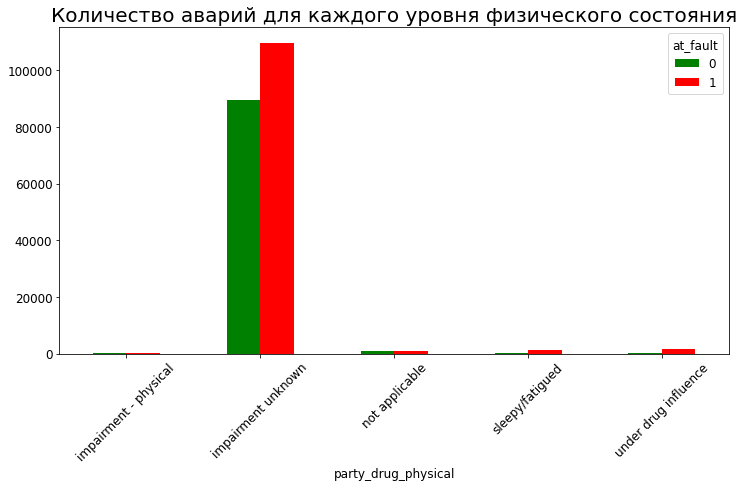

In [45]:
chart = df_of_collisions.groupby(
    ['party_drug_physical', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=45)
chart.set_title('Количество аварий для каждого уровня физического состояния', fontsize=20);

**Использование сотового телефона**

In [46]:
df_of_collisions['cellphone_in_use'].unique()

array([ 0., nan,  1.])

In [47]:
# контроль пропусков
df_of_collisions['cellphone_in_use'].isna().sum()

26146

Заполним пропуски значением unknown. Это позволит выделить случаи, когда у модели нет данных об использовании сотового телефона за рулем.

In [48]:
df_of_collisions['cellphone_in_use'].fillna('unknown', inplace=True)

Чтобы в дальнейшем у кодировщика OneHotEncoder не возникло трудностей при обработке числовых и строковых данных в одном столбе, изменим нули и единицы на no и yes.

In [49]:
df_of_collisions['cellphone_in_use'].replace(
    {0 : 'no',
     1 : 'yes'
    },
    inplace=True
)

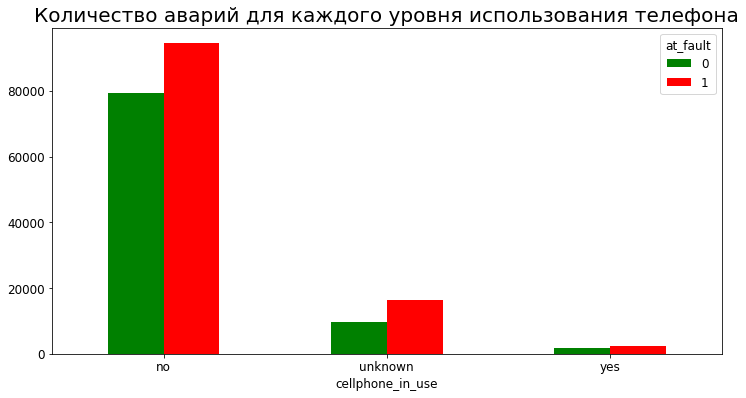

In [50]:
chart = df_of_collisions.groupby(
    ['cellphone_in_use', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий для каждого уровня использования телефона', fontsize=20);

Видим, что в каждой группе виновников ДТП примерно столько же, что и невиновных.

**Номер географических районов, где произошло ДТП**

In [51]:
# количество уникальных значений
df_of_collisions['county_city_location'].nunique()

513

In [52]:
# контроль пропусков
df_of_collisions['county_city_location'].isna().sum()

0

**Направление движения**

In [53]:
# количество уникальных значений
df_of_collisions['direction'].nunique()

4

In [54]:
df_of_collisions['direction'].value_counts()

north    44016
south    43526
west     35464
east     35013
Name: direction, dtype: int64

In [55]:
# контроль пропусков
df_of_collisions['direction'].isna().sum()

46354

In [56]:
# заполним пропуски значением unknown
df_of_collisions['direction'].fillna('unknown', inplace=True)

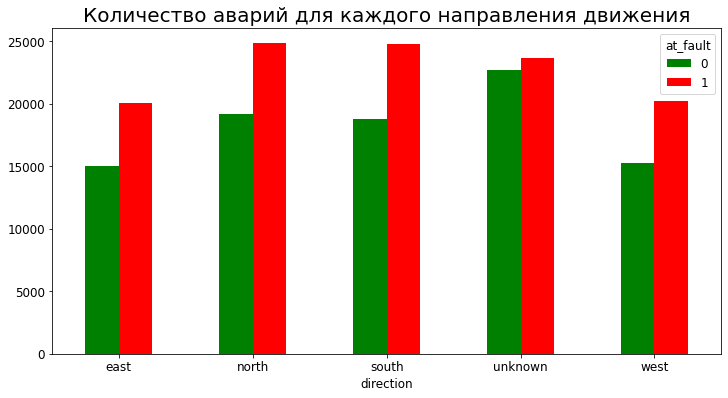

In [57]:
chart = df_of_collisions.groupby(
    ['direction', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий для каждого направления движения', fontsize=20);

Видим, что часто данные о направлении движения не указаны. С другой стороны, количество виновных и невиновных в ДТП примерно одинаково распределено во всех группах. Это говорит о том, что направление движения не оказывает существенного влияния на риск ДТП, можно данный признак не использовать для обучения модели.

**Погода**

In [58]:
# количество уникальных значений
df_of_collisions['weather_1'].nunique()

7

In [59]:
df_of_collisions['weather_1'].value_counts()

clear      163573
cloudy      30538
raining      8301
fog           616
snowing       456
other         175
wind           52
Name: weather_1, dtype: int64

In [60]:
# контроль пропусков
df_of_collisions['weather_1'].isna().sum()

662

Количество пропусков незначительное, можно их заполнить уже имеющимся словом 'other'.

In [61]:
# заполним пропуски значением other
df_of_collisions['weather_1'].fillna('other', inplace=True)

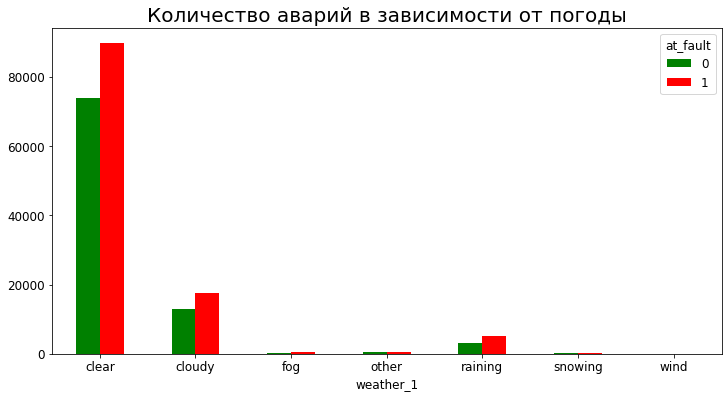

In [62]:
chart = df_of_collisions.groupby(
    ['weather_1', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий в зависимости от погоды', fontsize=20);

Большинство аварий произошло в ясную погоду. На втором месте – пасмурная и дождливая.

**Тип дороги**

In [63]:
# количество уникальных значений
df_of_collisions['location_type'].nunique()

3

In [64]:
df_of_collisions['location_type'].value_counts()

highway         72395
ramp            11779
intersection     4416
Name: location_type, dtype: int64

In [65]:
# контроль пропусков
df_of_collisions['location_type'].isna().sum()

115783

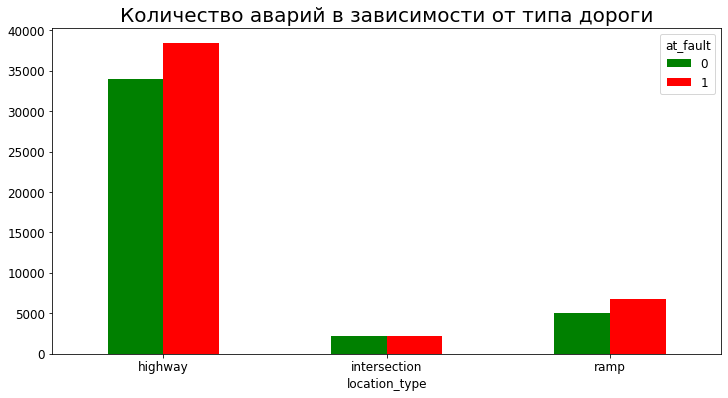

In [66]:
chart = df_of_collisions.groupby(
    ['location_type', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий в зависимости от типа дороги', fontsize=20);

Видим, что распределение виновных / невиновных в ДТП примерно одинаково независимо от типа дороги. Большинство аварий происходят на шоссе. Так как маршрут водителя обычно пролегает по шоссе, где много перекрестков, можно не учитывать этот параметр для обучения модели, так как место аварии нам заранее неизвестно.

**Тип дороги в зависимости от погоды**

In [67]:
# количество уникальных значений
df_of_collisions['road_surface'].nunique()

4

In [68]:
df_of_collisions['road_surface'].value_counts()

dry         182571
wet          19376
snowy          970
slippery       149
Name: road_surface, dtype: int64

In [69]:
# контроль пропусков
df_of_collisions['road_surface'].isna().sum()

1307

In [70]:
# заполним пропуски значением unknown
df_of_collisions['road_surface'].fillna('unknown', inplace=True)

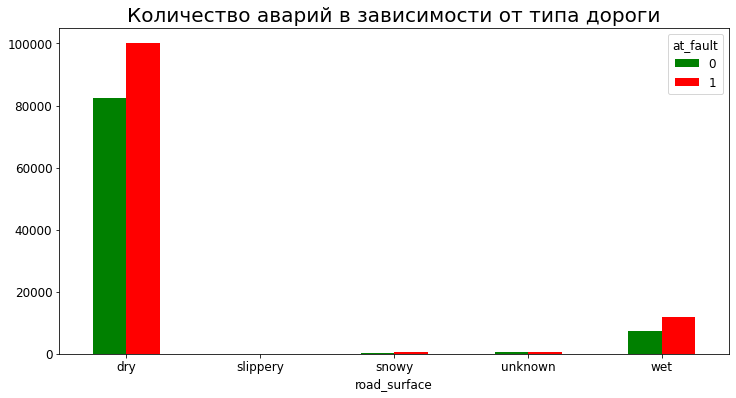

In [71]:
chart = df_of_collisions.groupby(
    ['road_surface', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий в зависимости от типа дороги', fontsize=20);

В большинстве случаем аварии происходят на сухой дороге. На втором месте – мокрая после дождя дорога.

**Состояние дороги**

In [72]:
# количество уникальных значений
df_of_collisions['road_condition_1'].nunique()

8

In [73]:
df_of_collisions['road_condition_1'].value_counts()

normal            196978
construction        3392
other                801
obstruction          750
holes                649
loose material       324
reduced width        226
flooded              114
Name: road_condition_1, dtype: int64

In [74]:
# контроль пропусков
df_of_collisions['road_condition_1'].isna().sum()

1139

In [75]:
# заполним пропуски значением other
df_of_collisions['road_condition_1'].fillna('other', inplace=True)

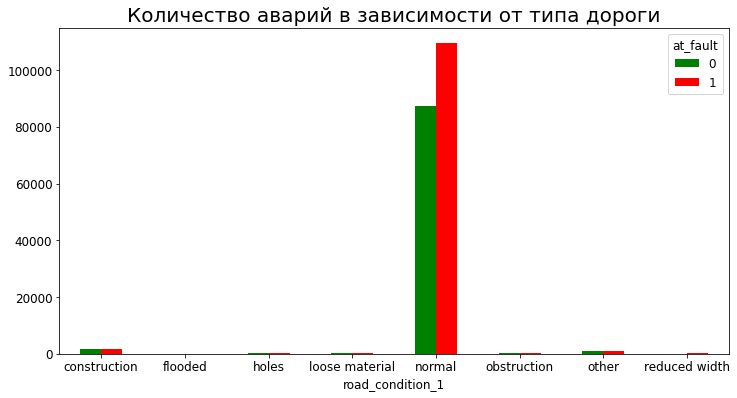

In [76]:
chart = df_of_collisions.groupby(
    ['road_condition_1', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий в зависимости от типа дороги', fontsize=20);

Большинство аварий произошло на дорогах в нормальном состоянии.

**Освещение**

In [77]:
# количество уникальных значений
df_of_collisions['lighting'].nunique()

5

In [78]:
# контроль пропусков
df_of_collisions['lighting'].isna().sum()

735

In [79]:
df_of_collisions['lighting'].value_counts()

daylight                                   140741
dark with street lights                     40223
dark with no street lights                  15223
dusk or dawn                                 6981
dark with street lights not functioning       470
Name: lighting, dtype: int64

Два состояния освещения - 'dark with street lights not functioning' и 'dark with no street lights' можно объединить в одно - 'dark'. При развертывании модели эту характеристику можно запонять в зависимоти от времени поездки.

In [80]:
df_of_collisions['lighting'].replace(
    {'dark with street lights not functioning' : 'dark',
     'dark with no street lights' : 'dark',
     'dark with street lights' : 'dark'}, 
    inplace=True
)

In [81]:
# заполним пропуски значением unknown
df_of_collisions['lighting'].fillna('unknown', inplace=True)

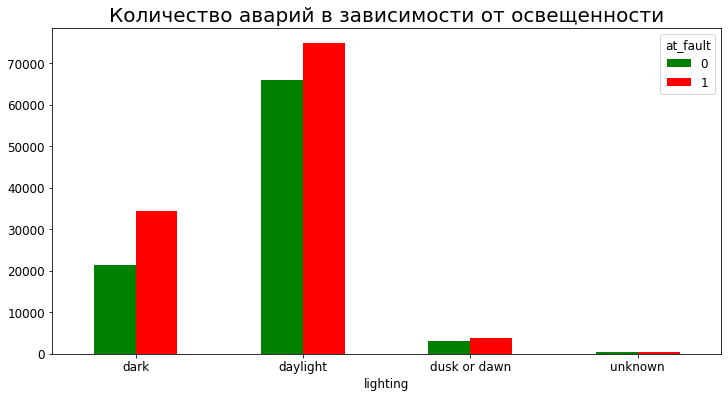

In [82]:
chart = df_of_collisions.groupby(
    ['lighting', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий в зависимости от освещенности', fontsize=20);

Больше всего аварий происходит в светлое время суток. На втором месте – ночное время.

**Тип кузова**

In [83]:
# количество уникальных значений
df_of_collisions['vehicle_type'].nunique()

5

In [84]:
# контроль пропусков
df_of_collisions['vehicle_type'].isna().sum()

101076

In [85]:
# заполним пропуски значением other
df_of_collisions['vehicle_type'].fillna('other', inplace=True)

In [86]:
df_of_collisions['vehicle_type'].value_counts()

other        101132
sedan         66710
coupe         30981
hatchback      3154
minivan        2396
Name: vehicle_type, dtype: int64

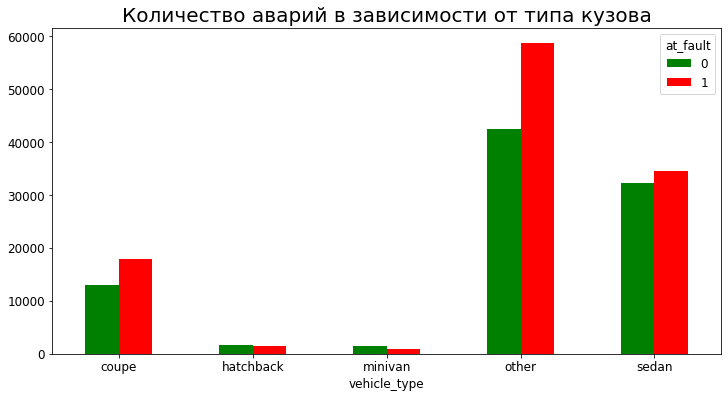

In [87]:
chart = df_of_collisions.groupby(
    ['vehicle_type', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий в зависимости от типа кузова', fontsize=20);

Видим, что тип кузова не оказывает особого влияния на вероятность аварии. Во всех группах распределение виновных / невиновных приблизительно одинаковое.

**Тип коробки передач**

In [88]:
# количество уникальных значений
df_of_collisions['vehicle_transmission'].nunique()

2

In [89]:
# контроль пропусков
df_of_collisions['vehicle_transmission'].isna().sum()

102734

In [90]:
# заполним пропуски значением unknown
df_of_collisions['vehicle_transmission'].fillna('unknown', inplace=True)

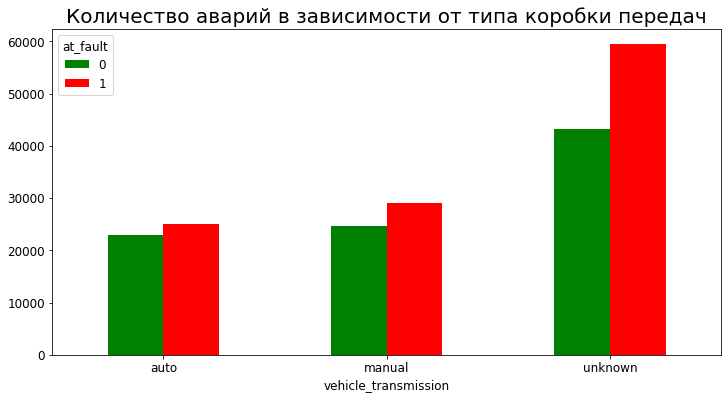

In [91]:
chart = df_of_collisions.groupby(
    ['vehicle_transmission', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий в зависимости от типа коробки передач', fontsize=20);

В большинстве случаев тип коробки передач неизвестен. Видим, то среди водителей с ручной КПП виновных в аварии немного больше, чем среди водителей с автоматической КПП.

**Возраст авто**

In [92]:
# количество уникальных значений
df_of_collisions['vehicle_age'].nunique()

20

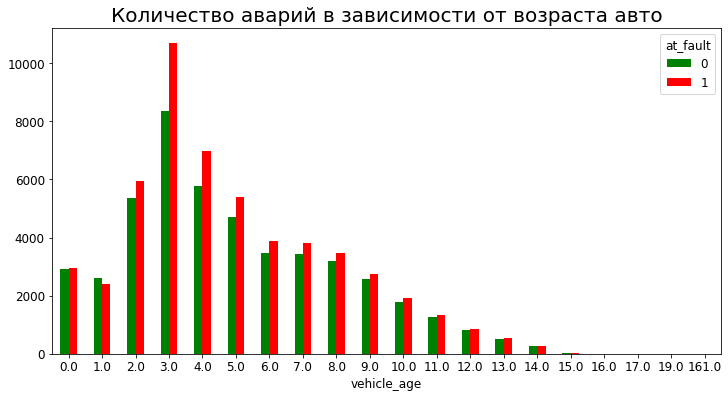

In [93]:
chart = df_of_collisions.groupby(
    ['vehicle_age', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=0)
chart.set_title('Количество аварий в зависимости от возраста авто', fontsize=20);

In [94]:
# контроль пропусков
df_of_collisions['vehicle_age'].isna().sum() / df_of_collisions.shape[0] * 100

50.91768482138052

Так как пропуски возраста авто содержатся в половине данных, то удалять их нельзя. Если заполнить их значением unknown, то столбец перейдет в категориальные переменные. При применении техники OHE работа с ним приведет к значительному росту размерности датасета.

Поэтому заполним пропуски модальным значением возраста авто.

In [95]:
age_mode = df_of_collisions['vehicle_age'].mode()
age_mode

0    3.0
dtype: float64

In [96]:
df_of_collisions['vehicle_age'].fillna(
    3.0,
    inplace=True
)

In [97]:
df_of_collisions['vehicle_age'].isna().sum()

0

In [98]:
df_of_collisions[df_of_collisions['vehicle_age'] == df_of_collisions['vehicle_age'].max()].shape[0]

4

Видим, что в данных встречаются автомобили с возрастом 161 год. Это явно некорректное значение. Так как таких строк всего 4, удалим их.

In [99]:
# контроль размерности 
df_of_collisions.shape

(204373, 17)

In [100]:
# удаление выбросов
df_of_collisions = df_of_collisions[df_of_collisions['vehicle_age'] < 100]

In [101]:
# контроль размерности 
df_of_collisions.shape

(204369, 17)

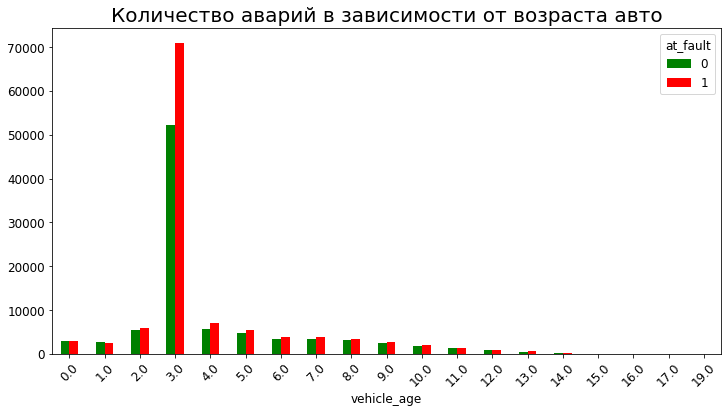

In [102]:
chart = df_of_collisions.groupby(
    ['vehicle_age', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=45)
chart.set_title('Количество аварий в зависимости от возраста авто', fontsize=20);

**Устройство управления**

In [103]:
df_of_collisions['control_device'].nunique()

4

In [104]:
df_of_collisions['control_device'].unique()

array(['functioning', 'none', None, 'obscured', 'not functioning'],
      dtype=object)

Пропуски заполним уже имеющимся в данных значением obscured.

In [105]:
df_of_collisions['control_device'].replace(
    {'none' : 'obscured',
     None : 'obscured'
    }, 
    inplace=True
)

In [106]:
df_of_collisions['control_device'].unique()

array(['functioning', 'obscured', 'not functioning'], dtype=object)

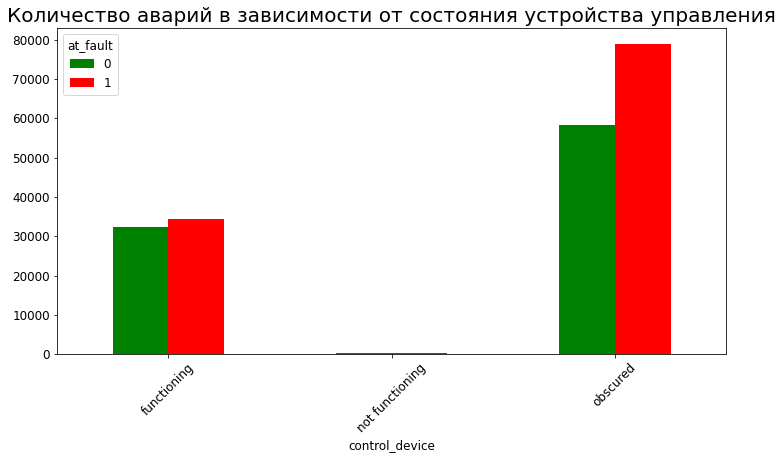

In [107]:
chart = df_of_collisions.groupby(
    ['control_device', 
     'at_fault']
).count()['collision_date'].unstack().plot(
    kind='bar', 
    figsize=(12, 6),
    color=['green', 'red'],
rot=45)
chart.set_title('Количество аварий в зависимости от состояния устройства управления', fontsize=20);

**Дата аварии**

Из даты вытащить только месяц, потому что у всех данных один и тот же год. При развёртывании модели конкретный день месяца не будет так важен.

In [108]:
new = pd.to_datetime(df_of_collisions['collision_date'])

In [109]:
df_of_collisions['month'] = pd.DatetimeIndex(pd.to_datetime(df_of_collisions['collision_date'])).month

In [110]:
df_of_collisions.head()

,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,county_city_location,distance,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,vehicle_type,vehicle_transmission,vehicle_age,month
0,1,had not been drinking,impairment unknown,no,1912,0.0,west,clear,None,dry,normal,dark,functioning,2012-01-18,other,unknown,3.0,1
1,1,impairment unknown,impairment unknown,no,3400,55.0,west,clear,None,dry,normal,dark,obscured,2012-01-09,other,unknown,3.0,1
2,1,impairment unknown,impairment unknown,no,3607,1056.0,west,cloudy,highway,wet,normal,daylight,obscured,2012-01-23,other,unknown,3.0,1
3,1,impairment unknown,impairment unknown,unknown,5002,2640.0,north,clear,highway,dry,normal,dark,obscured,2012-01-07,sedan,auto,4.0,1
4,0,had not been drinking,impairment unknown,no,1941,220.0,south,clear,None,dry,normal,dark,obscured,2012-01-08,other,unknown,3.0,1


In [111]:
# контроль пропусков
df_of_collisions.isna().sum()

at_fault                     0
party_sobriety               0
party_drug_physical          0
cellphone_in_use             0
county_city_location         0
distance                     0
direction                    0
weather_1                    0
location_type           115781
road_surface                 0
road_condition_1             0
lighting                     0
control_device               0
collision_date               0
vehicle_type                 0
vehicle_transmission         0
vehicle_age                  0
month                        0
dtype: int64

### Разбиение на обучающую и тестовую выборки

Уберем из данных характеристики: 
- direction - направление движения
- location_type - тип дороги
- collision_date - дата аварии, вместо нее будем использовать месяц

In [112]:
# контроль размерности 
df_of_collisions.shape

(204369, 18)

In [113]:
df_of_collisions.drop(['direction', 'location_type', 'collision_date'], axis = 1, inplace=True)

In [114]:
# контроль размерности 
df_of_collisions.shape

(204369, 15)

Выделим целевой признак и разобьем данные на тестовую и обучающую выборки в соотношении 1 : 4.

In [115]:
x_train, x_test, y_train, y_test = train_test_split(
    df_of_collisions.drop('at_fault', axis=1),
    df_of_collisions['at_fault'],
    test_size=.2,
    shuffle=True,
    random_state=RANDOM_STATE
)

In [116]:
# проверка правильности разбиения
x_train.shape[0] == y_train.shape[0], x_test.shape[0] == y_test.shape[0]

(True, True)

In [117]:
# проверка правильности разбиения
x_train.shape[0] + x_test.shape[0] == df_of_collisions.shape[0] 

True

In [118]:
# проверка правильности разбиения
y_train.shape[0] + y_test.shape[0] == df_of_collisions.shape[0] 

True

In [119]:
x_train.head()

,party_sobriety,party_drug_physical,cellphone_in_use,county_city_location,distance,weather_1,road_surface,road_condition_1,lighting,control_device,vehicle_type,vehicle_transmission,vehicle_age,month
59829,had not been drinking,impairment unknown,no,4900,1134.0,clear,dry,normal,dusk or dawn,obscured,coupe,manual,8.0,1
137479,had not been drinking,impairment unknown,no,4116,1056.0,clear,dry,normal,dark,obscured,other,unknown,3.0,3
144295,had not been drinking,impairment unknown,no,4316,1200.0,clear,dry,normal,daylight,obscured,other,unknown,3.0,1
195247,had not been drinking,impairment unknown,no,3010,1371.0,cloudy,dry,normal,daylight,obscured,sedan,auto,7.0,4
48374,had not been drinking,impairment unknown,no,4204,140.0,clear,dry,normal,daylight,obscured,other,unknown,3.0,2


### Предобработка данных

Выделим категориальные характеристики и количественные.

In [120]:
numeric = ['county_city_location', 'distance', 'month', 'vehicle_age']
categorical = [
    'party_sobriety',
    'party_drug_physical',
    'cellphone_in_use',
    'weather_1',
    'road_surface',
    'road_condition_1',
    'lighting',
    'control_device',
    'vehicle_type',
    'vehicle_transmission'
]

#### Обработка категориальных признаков 

In [121]:
# категориальные характеристики обучающего набора данных
cat_features = x_train.loc[:, categorical]

In [122]:
# категориальные характеристики тестового набора данных
cat_features_test = x_test.loc[:, categorical]

In [123]:
# будем использовать OrdinalEncoder
enc = OneHotEncoder(
    sparse=False,
    handle_unknown='ignore'
)

In [124]:
# обучаем на трейне и применяем
train_temp = enc.fit_transform(cat_features)

In [125]:
# вписываем новые признаки
cat_features[enc.get_feature_names()] = train_temp 

In [126]:
cat_features.head()

,party_sobriety,party_drug_physical,cellphone_in_use,weather_1,road_surface,road_condition_1,lighting,control_device,vehicle_type,vehicle_transmission,x0_had been drinking,x0_had not been drinking,x0_impairment unknown,x0_not applicable,x1_impairment - physical,x1_impairment unknown,x1_not applicable,x1_sleepy/fatigued,x1_under drug influence,x2_no,x2_unknown,x2_yes,x3_clear,x3_cloudy,x3_fog,x3_other,x3_raining,x3_snowing,x3_wind,x4_dry,x4_slippery,x4_snowy,x4_unknown,x4_wet,x5_construction,x5_flooded,x5_holes,x5_loose material,x5_normal,x5_obstruction,x5_other,x5_reduced width,x6_dark,x6_daylight,x6_dusk or dawn,x6_unknown,x7_functioning,x7_not functioning,x7_obscured,x8_coupe,x8_hatchback,x8_minivan,x8_other,x8_sedan,x9_auto,x9_manual,x9_unknown
59829,had not been drinking,impairment unknown,no,clear,dry,normal,dusk or dawn,obscured,coupe,manual,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
137479,had not been drinking,impairment unknown,no,clear,dry,normal,dark,obscured,other,unknown,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
144295,had not been drinking,impairment unknown,no,clear,dry,normal,daylight,obscured,other,unknown,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
195247,had not been drinking,impairment unknown,no,cloudy,dry,normal,daylight,obscured,sedan,auto,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
48374,had not been drinking,impairment unknown,no,clear,dry,normal,daylight,obscured,other,unknown,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [127]:
# удаляем старые признаки
cat_features.drop(categorical, axis=1, inplace=True)

In [128]:
# обработка тестовой выбоорки
test_temp = enc.transform(cat_features_test)

In [129]:
# вписываем новые признаки
cat_features_test[enc.get_feature_names()] = test_temp 

In [130]:
# удаляем старые признаки
cat_features_test.drop(categorical, axis=1, inplace=True)

In [131]:
cat_features_test.head()

,x0_had been drinking,x0_had not been drinking,x0_impairment unknown,x0_not applicable,x1_impairment - physical,x1_impairment unknown,x1_not applicable,x1_sleepy/fatigued,x1_under drug influence,x2_no,x2_unknown,x2_yes,x3_clear,x3_cloudy,x3_fog,x3_other,x3_raining,x3_snowing,x3_wind,x4_dry,x4_slippery,x4_snowy,x4_unknown,x4_wet,x5_construction,x5_flooded,x5_holes,x5_loose material,x5_normal,x5_obstruction,x5_other,x5_reduced width,x6_dark,x6_daylight,x6_dusk or dawn,x6_unknown,x7_functioning,x7_not functioning,x7_obscured,x8_coupe,x8_hatchback,x8_minivan,x8_other,x8_sedan,x9_auto,x9_manual,x9_unknown
59916,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
62168,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
54770,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
160520,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
39109,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [132]:
# тренировочная выборка
x_train_ohe =pd.merge(
    x_train[numeric],
    cat_features,
    left_index=True, 
    right_index=True)

In [133]:
x_train_ohe.head()

,county_city_location,distance,month,vehicle_age,x0_had been drinking,x0_had not been drinking,x0_impairment unknown,x0_not applicable,x1_impairment - physical,x1_impairment unknown,x1_not applicable,x1_sleepy/fatigued,x1_under drug influence,x2_no,x2_unknown,x2_yes,x3_clear,x3_cloudy,x3_fog,x3_other,x3_raining,x3_snowing,x3_wind,x4_dry,x4_slippery,x4_snowy,x4_unknown,x4_wet,x5_construction,x5_flooded,x5_holes,x5_loose material,x5_normal,x5_obstruction,x5_other,x5_reduced width,x6_dark,x6_daylight,x6_dusk or dawn,x6_unknown,x7_functioning,x7_not functioning,x7_obscured,x8_coupe,x8_hatchback,x8_minivan,x8_other,x8_sedan,x9_auto,x9_manual,x9_unknown
59829,4900,1134.0,1,8.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
137479,4116,1056.0,3,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
144295,4316,1200.0,1,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
195247,3010,1371.0,4,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
48374,4204,140.0,2,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


<div class="alert alert-info">
<font size="4"><b> Комментарий студента V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Огромное спасибо за этот комментарий и за код. Переписала свой, теперь все получилось.

Моя проблема была в том, что я не знала, как это сделать. В теории OneHotEncoder только упоминается, примеров кода нет. На то, чтобы разобраться только как его запустить у меня ушло несколько спринтов. Во многих статьях не рассказывается про параметр sparse, и из-за этого у меня все падало, пока случайно не наткнулась на его описание и примеры, как потом получившиеся столбцы добавить к датасету. То, что результат его работы – массив numpy, а датасет – в DataFrame из pandas тоже стало большой проблемой. В общем, освоила OneHotEncoder только по комментариям ревьюеров. 
Вопрос, что делать с неинформативными названиями столбцов тоже меня волновал всегда. Спасибо, что поделился опытом.

OrdinalEncoder побоялась использовать, чтобы не задать порядок внутри значений столбца в тех случаях, когда его нет.
    </font>
</div>


<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Да, знаю про эту проблему, что в теории не описано применение OHE, поэтому уже давно храню шаблончик для студентов. Рад, что пригодилось :)

In [134]:
# тестовая выборка
x_test_ohe =pd.merge(
    x_test[numeric],
    cat_features_test,
    left_index=True, 
    right_index=True)

In [135]:
x_test_ohe.head()

,county_city_location,distance,month,vehicle_age,x0_had been drinking,x0_had not been drinking,x0_impairment unknown,x0_not applicable,x1_impairment - physical,x1_impairment unknown,x1_not applicable,x1_sleepy/fatigued,x1_under drug influence,x2_no,x2_unknown,x2_yes,x3_clear,x3_cloudy,x3_fog,x3_other,x3_raining,x3_snowing,x3_wind,x4_dry,x4_slippery,x4_snowy,x4_unknown,x4_wet,x5_construction,x5_flooded,x5_holes,x5_loose material,x5_normal,x5_obstruction,x5_other,x5_reduced width,x6_dark,x6_daylight,x6_dusk or dawn,x6_unknown,x7_functioning,x7_not functioning,x7_obscured,x8_coupe,x8_hatchback,x8_minivan,x8_other,x8_sedan,x9_auto,x9_manual,x9_unknown
59916,1964,100.0,2,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
62168,4400,175.0,1,6.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
54770,1502,0.0,1,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
160520,1942,10.0,5,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
39109,0100,0.0,7,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Масштабирование признаков

Теперь масштабируем признаки так, чтобы их значения находились в диапазоне от 0 до 1. Будем использовать StandardScaler из Scikit Learn.

In [136]:
# инициализация
scaler = StandardScaler()

In [137]:
# обучение кодировщика
# и обработка тренировочной выборки
x_train_ohe_scaled = pd.DataFrame(scaler.fit_transform(x_train_ohe))
x_train_ohe_scaled.columns = x_train_ohe.columns

In [138]:
# обработка тестовой выборки
x_test_ohe_scaled = pd.DataFrame(scaler.transform(x_test_ohe))
x_test_ohe_scaled.columns = x_test_ohe.columns

In [139]:
# окончательная размерность выборок 
x_train_ohe_scaled.shape, x_test_ohe_scaled.shape

((163495, 51), (40874, 51))

### Метрика для оценки модели

Для задачи классификации главными метриками являются точность и полнота. 

Высокое значение **полноты** означает, что мы предотвратим почти все возможные ДТП. С другой стороны, при этом будет много ложных срабатываний, когда надежный водитель получит отказ, и каршеринг потеряет клиента и понесет убытки. 

Высокий уровень **точности** может означать, что наоборот, модель реже будет давать ответ, что поездка рискованная. В этом случае каршеринг понесет убытки, так как придется часто ремонтировать автомобили, а в худшем случае закупать новые. К тому же это может привести к удару по репутации: другие пользователи могут посчитать, что причина частых аварий у этой фирмы – ненадежный автопарк и предпочтут конкурентов.

Поэтому для оценки качества предсказаний разрабатываемой модели **будем использовать метрику F1**, которая позволит нам найти баланс между двумя этими крайностями. 


### DecisionTreeClassifier

In [140]:
# список гиперпараметров и их значений
search_space = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [5, 10, 12],
    'max_features' : ['auto', 'sqrt', 'log2']
}

In [141]:
model_DTC = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

In [142]:
GS_for_DTC = GridSearchCV(
    estimator=model_DTC,
    param_grid=search_space,
    scoring='f1',
    refit='f1',
    cv=3,
    verbose=10
)

In [143]:
# подбор гиперпараметров
# GS_for_DTC.fit(x_train_ohe_scaled, y_train)

```
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3; 1/27] START criterion=gini, max_depth=5, max_features=auto.............
[CV 1/3; 1/27] END criterion=gini, max_depth=5, max_features=auto; total time=   0.1s
[CV 2/3; 1/27] START criterion=gini, max_depth=5, max_features=auto.............
[CV 2/3; 1/27] END criterion=gini, max_depth=5, max_features=auto; total time=   0.1s
[CV 3/3; 1/27] START criterion=gini, max_depth=5, max_features=auto.............
[CV 3/3; 1/27] END criterion=gini, max_depth=5, max_features=auto; total time=   0.1s
[CV 1/3; 2/27] START criterion=gini, max_depth=5, max_features=sqrt.............
[CV 1/3; 2/27] END criterion=gini, max_depth=5, max_features=sqrt; total time=   0.1s
[CV 2/3; 2/27] START criterion=gini, max_depth=5, max_features=sqrt.............
[CV 2/3; 2/27] END criterion=gini, max_depth=5, max_features=sqrt; total time=   0.1s
[CV 3/3; 2/27] START criterion=gini, max_depth=5, max_features=sqrt.............
[CV 3/3; 2/27] END criterion=gini, max_depth=5, max_features=sqrt; total time=   0.1s
[CV 1/3; 3/27] START criterion=gini, max_depth=5, max_features=log2.............
[CV 1/3; 3/27] END criterion=gini, max_depth=5, max_features=log2; total time=   0.1s
[CV 2/3; 3/27] START criterion=gini, max_depth=5, max_features=log2.............
[CV 2/3; 3/27] END criterion=gini, max_depth=5, max_features=log2; total time=   0.1s
[CV 3/3; 3/27] START criterion=gini, max_depth=5, max_features=log2.............
[CV 3/3; 3/27] END criterion=gini, max_depth=5, max_features=log2; total time=   0.1s
[CV 1/3; 4/27] START criterion=gini, max_depth=10, max_features=auto............
[CV 1/3; 4/27] END criterion=gini, max_depth=10, max_features=auto; total time=   0.1s
[CV 2/3; 4/27] START criterion=gini, max_depth=10, max_features=auto............
[CV 2/3; 4/27] END criterion=gini, max_depth=10, max_features=auto; total time=   0.2s
[CV 3/3; 4/27] START criterion=gini, max_depth=10, max_features=auto............
[CV 3/3; 4/27] END criterion=gini, max_depth=10, max_features=auto; total time=   0.2s
[CV 1/3; 5/27] START criterion=gini, max_depth=10, max_features=sqrt............
[CV 1/3; 5/27] END criterion=gini, max_depth=10, max_features=sqrt; total time=   0.2s
[CV 2/3; 5/27] START criterion=gini, max_depth=10, max_features=sqrt............
[CV 2/3; 5/27] END criterion=gini, max_depth=10, max_features=sqrt; total time=   0.2s
[CV 3/3; 5/27] START criterion=gini, max_depth=10, max_features=sqrt............
[CV 3/3; 5/27] END criterion=gini, max_depth=10, max_features=sqrt; total time=   0.2s
[CV 1/3; 6/27] START criterion=gini, max_depth=10, max_features=log2............
[CV 1/3; 6/27] END criterion=gini, max_depth=10, max_features=log2; total time=   0.1s
[CV 2/3; 6/27] START criterion=gini, max_depth=10, max_features=log2............
[CV 2/3; 6/27] END criterion=gini, max_depth=10, max_features=log2; total time=   0.1s
[CV 3/3; 6/27] START criterion=gini, max_depth=10, max_features=log2............
[CV 3/3; 6/27] END criterion=gini, max_depth=10, max_features=log2; total time=   0.1s
[CV 1/3; 7/27] START criterion=gini, max_depth=12, max_features=auto............
[CV 1/3; 7/27] END criterion=gini, max_depth=12, max_features=auto; total time=   0.2s
[CV 2/3; 7/27] START criterion=gini, max_depth=12, max_features=auto............
[CV 2/3; 7/27] END criterion=gini, max_depth=12, max_features=auto; total time=   0.2s
[CV 3/3; 7/27] START criterion=gini, max_depth=12, max_features=auto............
[CV 3/3; 7/27] END criterion=gini, max_depth=12, max_features=auto; total time=   0.2s
[CV 1/3; 8/27] START criterion=gini, max_depth=12, max_features=sqrt............
[CV 1/3; 8/27] END criterion=gini, max_depth=12, max_features=sqrt; total time=   0.2s
[CV 2/3; 8/27] START criterion=gini, max_depth=12, max_features=sqrt............
[CV 2/3; 8/27] END criterion=gini, max_depth=12, max_features=sqrt; total time=   0.2s
[CV 3/3; 8/27] START criterion=gini, max_depth=12, max_features=sqrt............
[CV 3/3; 8/27] END criterion=gini, max_depth=12, max_features=sqrt; total time=   0.2s
[CV 1/3; 9/27] START criterion=gini, max_depth=12, max_features=log2............
[CV 1/3; 9/27] END criterion=gini, max_depth=12, max_features=log2; total time=   0.1s
[CV 2/3; 9/27] START criterion=gini, max_depth=12, max_features=log2............
[CV 2/3; 9/27] END criterion=gini, max_depth=12, max_features=log2; total time=   0.1s
[CV 3/3; 9/27] START criterion=gini, max_depth=12, max_features=log2............
[CV 3/3; 9/27] END criterion=gini, max_depth=12, max_features=log2; total time=   0.2s
[CV 1/3; 10/27] START criterion=entropy, max_depth=5, max_features=auto.........
[CV 1/3; 10/27] END criterion=entropy, max_depth=5, max_features=auto; total time=   0.1s
[CV 2/3; 10/27] START criterion=entropy, max_depth=5, max_features=auto.........
[CV 2/3; 10/27] END criterion=entropy, max_depth=5, max_features=auto; total time=   0.1s
[CV 3/3; 10/27] START criterion=entropy, max_depth=5, max_features=auto.........
[CV 3/3; 10/27] END criterion=entropy, max_depth=5, max_features=auto; total time=   0.1s
[CV 1/3; 11/27] START criterion=entropy, max_depth=5, max_features=sqrt.........
[CV 1/3; 11/27] END criterion=entropy, max_depth=5, max_features=sqrt; total time=   0.1s
[CV 2/3; 11/27] START criterion=entropy, max_depth=5, max_features=sqrt.........
[CV 2/3; 11/27] END criterion=entropy, max_depth=5, max_features=sqrt; total time=   0.1s
[CV 3/3; 11/27] START criterion=entropy, max_depth=5, max_features=sqrt.........
[CV 3/3; 11/27] END criterion=entropy, max_depth=5, max_features=sqrt; total time=   0.1s
[CV 1/3; 12/27] START criterion=entropy, max_depth=5, max_features=log2.........
[CV 1/3; 12/27] END criterion=entropy, max_depth=5, max_features=log2; total time=   0.1s
[CV 2/3; 12/27] START criterion=entropy, max_depth=5, max_features=log2.........
[CV 2/3; 12/27] END criterion=entropy, max_depth=5, max_features=log2; total time=   0.1s
[CV 3/3; 12/27] START criterion=entropy, max_depth=5, max_features=log2.........
[CV 3/3; 12/27] END criterion=entropy, max_depth=5, max_features=log2; total time=   0.1s
[CV 1/3; 13/27] START criterion=entropy, max_depth=10, max_features=auto........
[CV 1/3; 13/27] END criterion=entropy, max_depth=10, max_features=auto; total time=   0.2s
[CV 2/3; 13/27] START criterion=entropy, max_depth=10, max_features=auto........
[CV 2/3; 13/27] END criterion=entropy, max_depth=10, max_features=auto; total time=   0.2s
[CV 3/3; 13/27] START criterion=entropy, max_depth=10, max_features=auto........
[CV 3/3; 13/27] END criterion=entropy, max_depth=10, max_features=auto; total time=   0.2s
[CV 1/3; 14/27] START criterion=entropy, max_depth=10, max_features=sqrt........
[CV 1/3; 14/27] END criterion=entropy, max_depth=10, max_features=sqrt; total time=   0.2s
[CV 2/3; 14/27] START criterion=entropy, max_depth=10, max_features=sqrt........
[CV 2/3; 14/27] END criterion=entropy, max_depth=10, max_features=sqrt; total time=   0.2s
[CV 3/3; 14/27] START criterion=entropy, max_depth=10, max_features=sqrt........
[CV 3/3; 14/27] END criterion=entropy, max_depth=10, max_features=sqrt; total time=   0.2s
[CV 1/3; 15/27] START criterion=entropy, max_depth=10, max_features=log2........
[CV 1/3; 15/27] END criterion=entropy, max_depth=10, max_features=log2; total time=   0.1s
[CV 2/3; 15/27] START criterion=entropy, max_depth=10, max_features=log2........
[CV 2/3; 15/27] END criterion=entropy, max_depth=10, max_features=log2; total time=   0.1s
[CV 3/3; 15/27] START criterion=entropy, max_depth=10, max_features=log2........
[CV 3/3; 15/27] END criterion=entropy, max_depth=10, max_features=log2; total time=   0.1s
[CV 1/3; 16/27] START criterion=entropy, max_depth=12, max_features=auto........
[CV 1/3; 16/27] END criterion=entropy, max_depth=12, max_features=auto; total time=   0.2s
[CV 2/3; 16/27] START criterion=entropy, max_depth=12, max_features=auto........
[CV 2/3; 16/27] END criterion=entropy, max_depth=12, max_features=auto; total time=   0.2s
[CV 3/3; 16/27] START criterion=entropy, max_depth=12, max_features=auto........
[CV 3/3; 16/27] END criterion=entropy, max_depth=12, max_features=auto; total time=   0.2s
[CV 1/3; 17/27] START criterion=entropy, max_depth=12, max_features=sqrt........
[CV 1/3; 17/27] END criterion=entropy, max_depth=12, max_features=sqrt; total time=   0.2s
[CV 2/3; 17/27] START criterion=entropy, max_depth=12, max_features=sqrt........
[CV 2/3; 17/27] END criterion=entropy, max_depth=12, max_features=sqrt; total time=   0.2s
[CV 3/3; 17/27] START criterion=entropy, max_depth=12, max_features=sqrt........
[CV 3/3; 17/27] END criterion=entropy, max_depth=12, max_features=sqrt; total time=   0.2s
[CV 1/3; 18/27] START criterion=entropy, max_depth=12, max_features=log2........
[CV 1/3; 18/27] END criterion=entropy, max_depth=12, max_features=log2; total time=   0.2s
[CV 2/3; 18/27] START criterion=entropy, max_depth=12, max_features=log2........
[CV 2/3; 18/27] END criterion=entropy, max_depth=12, max_features=log2; total time=   0.2s
[CV 3/3; 18/27] START criterion=entropy, max_depth=12, max_features=log2........
[CV 3/3; 18/27] END criterion=entropy, max_depth=12, max_features=log2; total time=   0.2s
[CV 1/3; 19/27] START criterion=log_loss, max_depth=5, max_features=auto........
[CV 1/3; 19/27] END criterion=log_loss, max_depth=5, max_features=auto; total time=   0.1s
[CV 2/3; 19/27] START criterion=log_loss, max_depth=5, max_features=auto........
[CV 2/3; 19/27] END criterion=log_loss, max_depth=5, max_features=auto; total time=   0.1s
[CV 3/3; 19/27] START criterion=log_loss, max_depth=5, max_features=auto........
[CV 3/3; 19/27] END criterion=log_loss, max_depth=5, max_features=auto; total time=   0.1s
[CV 1/3; 20/27] START criterion=log_loss, max_depth=5, max_features=sqrt........
[CV 1/3; 20/27] END criterion=log_loss, max_depth=5, max_features=sqrt; total time=   0.1s
[CV 2/3; 20/27] START criterion=log_loss, max_depth=5, max_features=sqrt........
[CV 2/3; 20/27] END criterion=log_loss, max_depth=5, max_features=sqrt; total time=   0.1s
[CV 3/3; 20/27] START criterion=log_loss, max_depth=5, max_features=sqrt........
[CV 3/3; 20/27] END criterion=log_loss, max_depth=5, max_features=sqrt; total time=   0.1s
[CV 1/3; 21/27] START criterion=log_loss, max_depth=5, max_features=log2........
[CV 1/3; 21/27] END criterion=log_loss, max_depth=5, max_features=log2; total time=   0.1s
[CV 2/3; 21/27] START criterion=log_loss, max_depth=5, max_features=log2........
[CV 2/3; 21/27] END criterion=log_loss, max_depth=5, max_features=log2; total time=   0.1s
[CV 3/3; 21/27] START criterion=log_loss, max_depth=5, max_features=log2........
[CV 3/3; 21/27] END criterion=log_loss, max_depth=5, max_features=log2; total time=   0.1s
[CV 1/3; 22/27] START criterion=log_loss, max_depth=10, max_features=auto.......
[CV 1/3; 22/27] END criterion=log_loss, max_depth=10, max_features=auto; total time=   0.1s
[CV 2/3; 22/27] START criterion=log_loss, max_depth=10, max_features=auto.......
[CV 2/3; 22/27] END criterion=log_loss, max_depth=10, max_features=auto; total time=   0.1s
[CV 3/3; 22/27] START criterion=log_loss, max_depth=10, max_features=auto.......
[CV 3/3; 22/27] END criterion=log_loss, max_depth=10, max_features=auto; total time=   0.1s
[CV 1/3; 23/27] START criterion=log_loss, max_depth=10, max_features=sqrt.......
[CV 1/3; 23/27] END criterion=log_loss, max_depth=10, max_features=sqrt; total time=   0.1s
[CV 2/3; 23/27] START criterion=log_loss, max_depth=10, max_features=sqrt.......
[CV 2/3; 23/27] END criterion=log_loss, max_depth=10, max_features=sqrt; total time=   0.1s
[CV 3/3; 23/27] START criterion=log_loss, max_depth=10, max_features=sqrt.......
[CV 3/3; 23/27] END criterion=log_loss, max_depth=10, max_features=sqrt; total time=   0.1s
[CV 1/3; 24/27] START criterion=log_loss, max_depth=10, max_features=log2.......
[CV 1/3; 24/27] END criterion=log_loss, max_depth=10, max_features=log2; total time=   0.1s
[CV 2/3; 24/27] START criterion=log_loss, max_depth=10, max_features=log2.......
[CV 2/3; 24/27] END criterion=log_loss, max_depth=10, max_features=log2; total time=   0.1s
[CV 3/3; 24/27] START criterion=log_loss, max_depth=10, max_features=log2.......
[CV 3/3; 24/27] END criterion=log_loss, max_depth=10, max_features=log2; total time=   0.1s
[CV 1/3; 25/27] START criterion=log_loss, max_depth=12, max_features=auto.......
[CV 1/3; 25/27] END criterion=log_loss, max_depth=12, max_features=auto; total time=   0.1s
[CV 2/3; 25/27] START criterion=log_loss, max_depth=12, max_features=auto.......
[CV 2/3; 25/27] END criterion=log_loss, max_depth=12, max_features=auto; total time=   0.1s
[CV 3/3; 25/27] START criterion=log_loss, max_depth=12, max_features=auto.......
[CV 3/3; 25/27] END criterion=log_loss, max_depth=12, max_features=auto; total time=   0.1s
[CV 1/3; 26/27] START criterion=log_loss, max_depth=12, max_features=sqrt.......
[CV 1/3; 26/27] END criterion=log_loss, max_depth=12, max_features=sqrt; total time=   0.1s
[CV 2/3; 26/27] START criterion=log_loss, max_depth=12, max_features=sqrt.......
[CV 2/3; 26/27] END criterion=log_loss, max_depth=12, max_features=sqrt; total time=   0.1s
[CV 3/3; 26/27] START criterion=log_loss, max_depth=12, max_features=sqrt.......
[CV 3/3; 26/27] END criterion=log_loss, max_depth=12, max_features=sqrt; total time=   0.1s
[CV 1/3; 27/27] START criterion=log_loss, max_depth=12, max_features=log2.......
[CV 1/3; 27/27] END criterion=log_loss, max_depth=12, max_features=log2; total time=   0.1s
[CV 2/3; 27/27] START criterion=log_loss, max_depth=12, max_features=log2.......
[CV 2/3; 27/27] END criterion=log_loss, max_depth=12, max_features=log2; total time=   0.1s
[CV 3/3; 27/27] START criterion=log_loss, max_depth=12, max_features=log2.......
[CV 3/3; 27/27] END criterion=log_loss, max_depth=12, max_features=log2; total time=   0.1s
GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 12],
                         'max_features': ['auto', 'sqrt', 'log2']},
             refit='f1', scoring='f1', verbose=10)
```

In [144]:
# значение f1 лучшего эстиматора
# GS_for_DTC.best_score_

```
0.6545290369817177
```

In [145]:
# лучшие параметры модели
# GS_for_DTC.best_params_

```
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2'}
```

### RandomForestClassifier

In [146]:
# список гиперпараметров и их значений
search_space = {
    'n_estimators' : [100, 200],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [5, 10],
    'max_features' : ['auto', 'sqrt', 'log2']
}

In [147]:
model_RFC = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

In [148]:
GS_for_RFC = GridSearchCV(
    estimator=model_RFC,
    param_grid=search_space,
    scoring='f1',
    refit='f1',
    cv=3,
    verbose=2
)

In [149]:
# подбор гиперпараметров
# GS_for_RFC.fit(x_train_ohe_scaled, y_train)

```
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100; total time=   3.8s
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100; total time=   3.9s
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100; total time=   3.9s
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200; total time=   7.6s
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200; total time=   7.7s
[CV] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200; total time=   7.7s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   3.9s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   3.9s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   3.8s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200; total time=   7.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200; total time=   7.8s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200; total time=   7.8s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=100; total time=   3.2s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=100; total time=   3.3s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=100; total time=   3.3s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=200; total time=   6.4s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=200; total time=   6.3s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=200; total time=   6.5s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100; total time=   6.7s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100; total time=   6.7s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100; total time=   6.9s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200; total time=  13.8s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200; total time=  13.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200; total time=  13.8s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   6.9s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   6.8s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   6.9s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=  14.2s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=  13.6s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=  13.9s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   5.6s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   5.4s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   5.7s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=  11.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=  11.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=  11.2s
[CV] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100; total time=   3.9s
[CV] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100; total time=   3.9s
[CV] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100; total time=   3.8s
[CV] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200; total time=   7.5s
[CV] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200; total time=   7.6s
[CV] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200; total time=   8.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100; total time=   3.9s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100; total time=   4.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100; total time=   3.9s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=200; total time=   7.4s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=200; total time=   7.6s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=200; total time=   7.6s
[CV] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=100; total time=   3.2s
[CV] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=100; total time=   3.3s
[CV] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=100; total time=   3.2s
[CV] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=200; total time=   6.5s
[CV] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=200; total time=   6.4s
[CV] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=200; total time=   6.4s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100; total time=   7.0s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100; total time=   6.7s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100; total time=   7.1s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200; total time=  13.7s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200; total time=  13.5s
[CV] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200; total time=  14.2s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100; total time=   6.9s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100; total time=   6.6s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100; total time=   6.9s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200; total time=  13.5s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200; total time=  13.2s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200; total time=  13.3s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   5.7s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   5.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   5.6s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=200; total time=  11.3s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=200; total time=  11.1s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=200; total time=  11.3s
[CV] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, n_estimators=200; total time=   0.2s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=auto, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=auto, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=auto, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=auto, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=auto, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=auto, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=log2, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=log2, n_estimators=200; total time=   0.1s
[CV] END criterion=log_loss, max_depth=10, max_features=log2, n_estimators=200; total time=   0.1s
GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200]},
             refit='f1', scoring='f1', verbose=2)
```

In [150]:
# значение f1 лучшего эстиматора
# GS_for_RFC.best_score_

```
0.4911535195260301
```

In [151]:
# GS_for_RFC.best_params_

```
{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 200}
```

### LGBMClassifier

In [152]:
# список гиперпараметров и их значений
search_space = {
    'n_jobs' : [6, 8],
    'learning_rate' : [0.1],
    'n_estimators' : [50, 100, 200],
    'max_depth' : [5, 10],
    'num_leaves' : [10, 20]
}

In [153]:
model_LGBMR = LGBMClassifier(
    random_state=RANDOM_STATE,
    force_row_wise=True
)

In [154]:
GS_for_LGBMR = GridSearchCV(
    estimator=model_LGBMR,
    param_grid=search_space,
    scoring='f1',
    refit='f1',
    cv=3,
    verbose=10
)

In [155]:
# подбор гиперпараметров
# GS_for_LGBMR.fit(x_train_ohe_scaled, y_train)

```
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=10
[CV 1/3; 1/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=10; total time=  19.7s
[CV 2/3; 1/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=10
[CV 2/3; 1/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=10; total time=  12.9s
[CV 3/3; 1/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=10
[CV 3/3; 1/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=10; total time=  11.7s
[CV 1/3; 2/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=20
[CV 1/3; 2/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=20; total time=  17.8s
[CV 2/3; 2/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=20
[CV 2/3; 2/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=20; total time=  17.6s
[CV 3/3; 2/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=20
[CV 3/3; 2/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=6, num_leaves=20; total time=  15.0s
[CV 1/3; 3/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=10
[CV 1/3; 3/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=10; total time= 1.0min
[CV 2/3; 3/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=10
[CV 2/3; 3/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=10; total time= 1.0min
[CV 3/3; 3/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=10
[CV 3/3; 3/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=10; total time= 1.0min
[CV 1/3; 4/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=20
[CV 1/3; 4/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=20; total time= 1.8min
[CV 2/3; 4/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=20
[CV 2/3; 4/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=20; total time= 1.8min
[CV 3/3; 4/24] START learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=20
[CV 3/3; 4/24] END learning_rate=0.1, max_depth=5, n_estimators=50, n_jobs=8, num_leaves=20; total time= 1.0min
[CV 1/3; 5/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=10
[CV 1/3; 5/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=10; total time=  16.9s
[CV 2/3; 5/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=10
[CV 2/3; 5/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=10; total time=  16.7s
[CV 3/3; 5/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=10
[CV 3/3; 5/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=10; total time=  16.8s
[CV 1/3; 6/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=20
[CV 1/3; 6/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=20; total time=  19.8s
[CV 2/3; 6/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=20
[CV 2/3; 6/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=20; total time=  22.2s
[CV 3/3; 6/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=20
[CV 3/3; 6/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=6, num_leaves=20; total time=  28.3s
[CV 1/3; 7/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=10
[CV 1/3; 7/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=10; total time= 1.6min
[CV 2/3; 7/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=10
[CV 2/3; 7/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=10; total time= 1.8min
[CV 3/3; 7/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=10
[CV 3/3; 7/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=10; total time= 1.8min
[CV 1/3; 8/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=20
[CV 1/3; 8/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=20; total time= 2.3min
[CV 2/3; 8/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=20
[CV 2/3; 8/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=20; total time= 1.9min
[CV 3/3; 8/24] START learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=20
[CV 3/3; 8/24] END learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=8, num_leaves=20; total time= 1.4min
[CV 1/3; 9/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=10
[CV 1/3; 9/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=10; total time=  22.7s
[CV 2/3; 9/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=10
[CV 2/3; 9/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=10; total time=  22.4s
[CV 3/3; 9/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=10
[CV 3/3; 9/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=10; total time=  15.0s
[CV 1/3; 10/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=20
[CV 1/3; 10/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=20; total time=  20.5s
[CV 2/3; 10/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=20
[CV 2/3; 10/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=20; total time=  15.7s
[CV 3/3; 10/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=20
[CV 3/3; 10/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=6, num_leaves=20; total time=  10.2s
[CV 1/3; 11/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=10
[CV 1/3; 11/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=10; total time=  38.4s
[CV 2/3; 11/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=10
[CV 2/3; 11/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=10; total time=  38.8s
[CV 3/3; 11/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=10
[CV 3/3; 11/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=10; total time=  41.0s
[CV 1/3; 12/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=20
[CV 1/3; 12/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=20; total time=  42.4s
[CV 2/3; 12/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=20
[CV 2/3; 12/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=20; total time=  39.5s
[CV 3/3; 12/24] START learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=20
[CV 3/3; 12/24] END learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=8, num_leaves=20; total time=  38.4s
[CV 1/3; 13/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=10
[CV 1/3; 13/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=10; total time=   3.6s
[CV 2/3; 13/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=10
[CV 2/3; 13/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=10; total time=   3.4s
[CV 3/3; 13/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=10
[CV 3/3; 13/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=10; total time=   3.2s
[CV 1/3; 14/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=20
[CV 1/3; 14/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=20; total time=   4.3s
[CV 2/3; 14/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=20
[CV 2/3; 14/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=20; total time=   4.4s
[CV 3/3; 14/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=20
[CV 3/3; 14/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=6, num_leaves=20; total time=   4.1s
[CV 1/3; 15/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=10
[CV 1/3; 15/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=10; total time=  10.3s
[CV 2/3; 15/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=10
[CV 2/3; 15/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=10; total time=  11.6s
[CV 3/3; 15/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=10
[CV 3/3; 15/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=10; total time=  11.2s
[CV 1/3; 16/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=20
[CV 1/3; 16/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=20; total time=  19.0s
[CV 2/3; 16/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=20
[CV 2/3; 16/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=20; total time=  16.7s
[CV 3/3; 16/24] START learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=20
[CV 3/3; 16/24] END learning_rate=0.1, max_depth=10, n_estimators=50, n_jobs=8, num_leaves=20; total time=  11.1s
[CV 1/3; 17/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=10
[CV 1/3; 17/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=10; total time=   5.6s
[CV 2/3; 17/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=10
[CV 2/3; 17/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=10; total time=   5.7s
[CV 3/3; 17/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=10
[CV 3/3; 17/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=10; total time=   5.0s
[CV 1/3; 18/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=20
[CV 1/3; 18/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=20; total time=   6.7s
[CV 2/3; 18/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=20
[CV 2/3; 18/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=20; total time=   7.9s
[CV 3/3; 18/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=20
[CV 3/3; 18/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=6, num_leaves=20; total time=   6.7s
[CV 1/3; 19/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=10
[CV 1/3; 19/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=10; total time=  22.0s
[CV 2/3; 19/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=10
[CV 2/3; 19/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=10; total time=  23.4s
[CV 3/3; 19/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=10
[CV 3/3; 19/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=10; total time=  28.3s
[CV 1/3; 20/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=20
[CV 1/3; 20/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=20; total time=  22.7s
[CV 2/3; 20/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=20
[CV 2/3; 20/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=20; total time=  30.2s
[CV 3/3; 20/24] START learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=20
[CV 3/3; 20/24] END learning_rate=0.1, max_depth=10, n_estimators=100, n_jobs=8, num_leaves=20; total time=  22.8s
[CV 1/3; 21/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=10
[CV 1/3; 21/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=10; total time=  10.3s
[CV 2/3; 21/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=10
[CV 2/3; 21/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=10; total time=   9.6s
[CV 3/3; 21/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=10
[CV 3/3; 21/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=10; total time=  10.0s
[CV 1/3; 22/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=20
[CV 1/3; 22/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=20; total time=  11.4s
[CV 2/3; 22/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=20
[CV 2/3; 22/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=20; total time=  11.4s
[CV 3/3; 22/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=20
[CV 3/3; 22/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=6, num_leaves=20; total time=  11.6s
[CV 1/3; 23/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=10
[CV 1/3; 23/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=10; total time=  41.8s
[CV 2/3; 23/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=10
[CV 2/3; 23/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=10; total time=  41.2s
[CV 3/3; 23/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=10
[CV 3/3; 23/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=10; total time=  31.1s
[CV 1/3; 24/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=20
[CV 1/3; 24/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=20; total time=  48.8s
[CV 2/3; 24/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=20
[CV 2/3; 24/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=20; total time=  43.4s
[CV 3/3; 24/24] START learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=20
[CV 3/3; 24/24] END learning_rate=0.1, max_depth=10, n_estimators=200, n_jobs=8, num_leaves=20; total time=  52.3s
GridSearchCV(cv=3,
             estimator=LGBMClassifier(force_row_wise=True, random_state=12345),
             param_grid={'learning_rate': [0.1], 'max_depth': [5, 10],
                         'n_estimators': [50, 100, 200], 'n_jobs': [6, 8],
                         'num_leaves': [10, 20]},
             refit='f1', scoring='f1', verbose=10)
```

In [156]:
# значение f1 лучшего эстиматора
# GS_for_LGBMR.best_score_

```
GS_for_LGBMR.best_score_
0.6083601487864329
```

### CatBoostClassifier

In [157]:
column_transform = ColumnTransformer([('n', StandardScaler(), numeric)], remainder='passthrough')
scaled_X = column_transform.fit_transform(x_train)
new_df = pd.DataFrame(scaled_X)
new_df = new_df.infer_objects() # converts the datatype to their most accurate datatype
cat_features_new = [new_df.columns.get_loc(col) for col in new_df.select_dtypes(include=['object', 'bool']).columns]

In [158]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.617718,0.053446,-1.252337,1.697448,had not been drinking,impairment unknown,no,clear,dry,normal,dusk or dawn,obscured,coupe,manual
1,1.016006,0.044375,-0.063856,-0.387949,had not been drinking,impairment unknown,no,clear,dry,normal,dark,obscured,other,unknown
2,1.169504,0.061122,-1.252337,-0.387949,had not been drinking,impairment unknown,no,clear,dry,normal,daylight,obscured,other,unknown
3,0.167163,0.081008,0.530384,1.280369,had not been drinking,impairment unknown,no,cloudy,dry,normal,daylight,obscured,sedan,auto
4,1.083546,-0.062149,-0.658097,-0.387949,had not been drinking,impairment unknown,no,clear,dry,normal,daylight,obscured,other,unknown


In [159]:
# список гиперпараметров и их значений
search_space = {
    'learning_rate' : [0.1],
    'n_estimators' : [100, 200],
    'max_depth' : [5, 10], 
    'reg_lambda' : [0.1, 0.01]
}

In [160]:
model_CBR = CatBoostClassifier(
    loss_function='Logloss',
    cat_features=cat_features_new,
    random_state=RANDOM_STATE,
    verbose=0
)

In [161]:
GS_for_CBR = GridSearchCV(
    estimator=model_CBR,
    param_grid=search_space,
    scoring='f1',
    refit='f1',
    cv=3,
    verbose=4 
)

In [162]:
# подбор гиперпараметров
# GS_for_CBR.fit(new_df, y_train)

```
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.1; total time=   9.9s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.1; total time=   9.2s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.1; total time=   8.3s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.01; total time=   9.1s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.01; total time=   8.4s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0.01; total time=   8.5s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0.1; total time=  38.0s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0.1; total time=  38.7s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0.1; total time=  38.6s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0.01; total time=  37.8s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0.01; total time=  37.9s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0.01; total time=  37.2s
[CV 1/3] END learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0.1; total time=  12.9s
[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0.1; total time=  13.9s
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0.1; total time=  15.1s
[CV 1/3] END learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0.01; total time=  13.4s
[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0.01; total time=  12.6s
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0.01; total time=  12.8s
[CV 1/3] END learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0.1; total time= 1.7min
[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0.1; total time= 1.7min
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0.1; total time= 1.6min
[CV 1/3] END learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0.01; total time= 1.7min
[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0.01; total time= 1.7min
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0.01; total time= 1.6min
```

In [163]:
# GS_for_CBR.best_score_

```
0.6075426062216208
```

In [164]:
# GS_for_CBR.best_params_

```
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 0.1}
```

### Сравнение моделей

|Модель|F1|
|:---|:--|
|DecisionTreeClassifier|0.6542|
|RandomForestClassifier|0.4916|
|LGBMClassifier|0.6083|
|CatBoostClassifier|0.6075|


Самый высокий показатель F1 = 0.6542 у DecisionTreeClassifier с гиперпараметрами {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2'}

## Анализ лучшей модели в работе

### Матрица ошибок

In [165]:
model = DecisionTreeClassifier(
    class_weight='balanced', 
    criterion='entropy',
    max_depth=5, 
    max_features='log2', 
    random_state=12345
)

In [166]:
model.fit(x_train_ohe_scaled, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features='log2', random_state=12345)

In [167]:
predictions = model.predict(x_test_ohe_scaled)

In [168]:
f1_score(y_test, predictions)

0.652732997003376

Показатель F1 на тестовой выборке оказался немного выше, чем на обучающей. 

In [169]:
cf_matrix = confusion_matrix(predictions, y_test, normalize='true')
cf_matrix

array([[0.49427833, 0.50572167],
       [0.42712564, 0.57287436]])

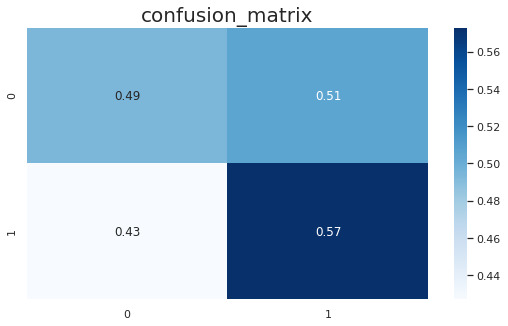

In [170]:
sns.set(rc={'figure.figsize':(9, 5)})
chart = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
chart.set_title('confusion_matrix', fontsize='20');


Из матрицы ошибок видно, что полнота прогноза составляет 57 %.

In [171]:
y_score = model.predict_proba (x_test_ohe_scaled)[:, 1]

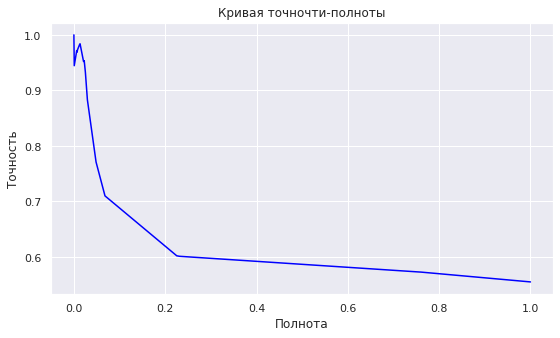

In [172]:
# расчет точности и полноты
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

# построение кривой точности-полноты
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

ax.set_title('Кривая точности-полноты')
ax.set_ylabel('Точность')
ax.set_xlabel('Полнота')

plt.show() 

Из кривой точности-полноты видно, что если повысить полноту прогнозов, то точность при этом снизится очень быстро. На практике это означает, что часто будут возникать ситуации, когда будет отказано в аренде авто надежному водителю. Это приведет к тому, что количество клиентов будет падать. Следовательно, надо улучшать качество модели за счет сбора дополнительной информации.

### Проведите анализ важности факторов ДТП

Для анализа важности основных факторов, влияющих на важность ДТП будем использовать параметр feature_importances_ модели DecisionTreeClassifier.


In [173]:
attr = x_test_ohe_scaled.columns
sorted(zip(model.feature_importances_, attr), reverse=True)

[(0.3855356271128697, 'x1_under drug influence'),
 (0.3171431950781938, 'x1_sleepy/fatigued'),
 (0.14050933956930714, 'x7_functioning'),
 (0.03874497689366412, 'x3_raining'),
 (0.024296603394954264, 'x3_clear'),
 (0.0223195857034675, 'x8_other'),
 (0.018884347051120073, 'x4_snowy'),
 (0.012931858126735675, 'month'),
 (0.010283112839649194, 'x8_hatchback'),
 (0.00789783792442593, 'distance'),
 (0.0053862340333819085, 'x6_daylight'),
 (0.003251262887835838, 'x6_dark'),
 (0.003202197392310108, 'x5_holes'),
 (0.002315705152544716, 'x9_auto'),
 (0.0018120820251621849, 'county_city_location'),
 (0.0018073248059792078, 'x4_wet'),
 (0.0015663878951067698, 'x8_coupe'),
 (0.0010233553747555412, 'x9_unknown'),
 (0.000699591426737351, 'x2_no'),
 (0.00030510066057793853, 'x2_unknown'),
 (8.42746512209067e-05, 'x2_yes'),
 (0.0, 'x9_manual'),
 (0.0, 'x8_sedan'),
 (0.0, 'x8_minivan'),
 (0.0, 'x7_obscured'),
 (0.0, 'x7_not functioning'),
 (0.0, 'x6_unknown'),
 (0.0, 'x6_dusk or dawn'),
 (0.0, 'x5_reduc

Видим, что самыми важными характеристиками оказались 

- физическое состояние участника с учётом принятых лекарств
- усталость водителя
- состояние прибора управления
- погода.


Изучим первые два фактора подробнее. Выясним, какой процент виновников аварии среди водителей, находившихся под воздействием наркотических веществ или лекарств или с высокой стпенью усталости.

In [174]:
drug_data = df_of_collisions[
    df_of_collisions['party_drug_physical'] == 'under drug influence'
]['at_fault'].value_counts() / df_of_collisions[
    df_of_collisions['party_drug_physical'] == 'under drug influence'
].shape[0] * 100
drug_data

1    91.33515
0     8.66485
Name: at_fault, dtype: float64

No handles with labels found to put in legend.


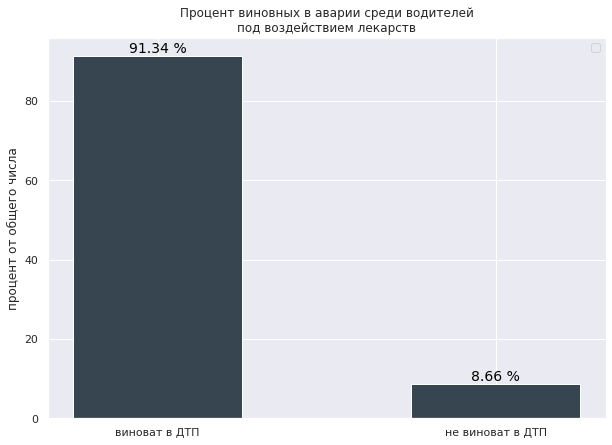

In [175]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.rc('font', size=14)

ax.bar(
    ["виноват в ДТП", "не виноват в ДТП"], 
    drug_data,
    color='#36454f', 
    width = 0.5
)
labels =[str(round(i, 2))+' %' for i in drug_data]

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, 
        height *1.001, 
        label, 
        ha="center", 
        va="bottom", 
        color='black'
    )


ax.set_ylabel('процент от общего числа')
ax.set_title('Процент виновных в аварии среди водителей\nпод воздействием лекарств')
ax.legend()
plt.show()

In [176]:
# процент виновных в ДТП среди уставших водителей
sleepy_data = df_of_collisions[
    df_of_collisions['party_drug_physical'] == 'sleepy/fatigued'
]['at_fault'].value_counts() / df_of_collisions[
    df_of_collisions['party_drug_physical'] == 'sleepy/fatigued'
].shape[0] * 100

In [177]:
sleepy_data

1    96.232877
0     3.767123
Name: at_fault, dtype: float64

No handles with labels found to put in legend.


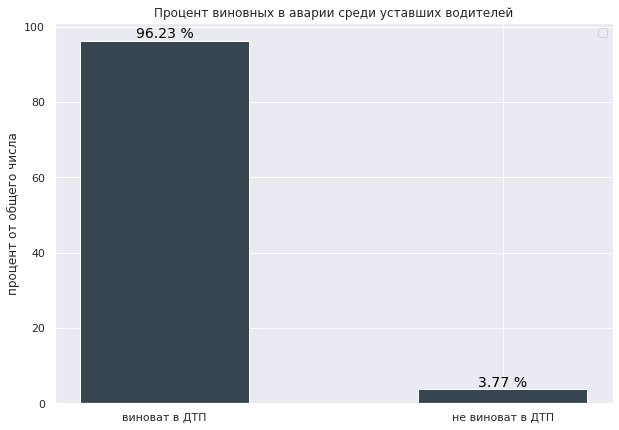

In [178]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.rc('font', size=14)

ax.bar(
    ["виноват в ДТП", "не виноват в ДТП"], 
    sleepy_data,
    color='#36454f', 
    width = 0.5
)
labels =[str(round(i, 2))+' %' for i in sleepy_data]

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height *1.001, label, ha="center", va="bottom", color='black'
    )


ax.set_ylabel('процент от общего числа')
ax.set_title('Процент виновных в аварии среди уставших водителей')
ax.legend()
plt.show()

Обе диаграммы показывают, что воздействие наркотических веществ или лекарств и усталость водителя значительно повышает риск аварии. 

Сейчас во многих странах разрабатываются устройства, определяющие, находится ли водитель под действием наркотических веществ. Можно их тоже установить в автомобиль.    

Перед каждой поездкой можно приводить водителям статистику аварий в состоянии усталости и рекомендовать оценть свое состяние и перенести поезку в случае плохого самочувсвия.

## Общий вывод по модели

Я считаю, что создание адекватной системы оценки риска при выдаче авто возможно, но затруднено. Необходимо собрать дополнительные данные для построения модели с большей полнотой предсказаний. 

Рекомендации по сбору данных:
    
1.	Собрать данные о предполагаемом маршруте путешествия. Это позволит модели получить информацию о состоянии дорог до поездки.
2.	Связать работу модели с навигатором в авто. Это позволит использовать данные о текущем трафике.
3.	Собрать данные о наиболее аварийных участках той местности, на территории которой предоставляются услуги каршеринга. Тогда в сочетании с предполагаемым маршрутом можно будет точнее рассчитать степень риска. Со временем можно задуматься о создании рекомендательной системы, которая будет генерировать более безопасный маршрут.
4.	При оформлении аренды машины просить водителя указывать серию и номер водительских прав. На сайте ГИБДД можно найти решение суда о лишении прав водителя, таким образом мы снизим риски на дорогах. Также существуют сервисы и порталы, которые предоставляют информацию о прошлых авариях по правам.


# Вывод

**Задача**

Поступил заказ от каршеринговой компании: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

**Основные результаты**

Проведен **предварительный анализ данных**. На его основе отобраны признаки, которые будут переданы модели для обучения.

Проведена **предварительная обработка данных**. Удалены дубликаты, заполнены пропуски. Подготовлены выборки для обучения и тестирования моделей. Проведено One-Hot кодирование категориальных признаков, затем масштабирование всех признаков.

Подобраны гиперпараметры для четырех моделей: **LGBMClassifier, CatBoostClassifier, DecisionTreeClassifier, RandomForestClassifier**. 

Качество модели оценивалось по **метрике F1**.

**Лучшей** оказалась модель **DecisionTreeClassifier с гиперпараметрами**:
- class_weight='balanced', 
- criterion='entropy',
- max_depth=5, 
- max_features='log2', 
- random_state=12345

Показатель F1 на тестовой выборке составил 0,58.

Построена кривая точности-полноты. Проведен **анализ важности признаков**. 
Самыми важными характеристиками оказались 
- физическое состояние участника с учётом принятых лекарств
- усталость водителя
- состояние прибора управления
- погода.

По результатам разработки модели сформулированы **рекомендации по сбору данных**:
    
1.	Собрать данные о предполагаемом маршруте путешествия. Это позволит модели получить информацию о состоянии дорог до поездки.
2.	Связать работу модели с навигатором в авто. Это позволит использовать данные о текущем трафике.
3.	Собрать данные о наиболее аварийных участках той местности, на территории которой предоставляются услуги каршеринга. Тогда в сочетании с предполагаемым маршрутом можно будет точнее рассчитать степень риска. Со временем можно задуматься о создании рекомендательной системы, которая будет генерировать более безопасный маршрут.
4.	При оформлении аренды машины просить водителя указывать серию и номер водительских прав. На сайте ГИБДД можно найти решение суда о лишении прав водителя, таким образом мы снизим риски на дорогах. Также существуют сервисы и порталы, которые предоставляют информацию о прошлых авариях по правам.
